# Detrending Light Curve Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import exoplanet as xo
from scipy.interpolate import interp1d


xo.utils.docs_setup()
print(f"exoplanet.__version__ = '{xo.__version__}'")

exoplanet.__version__ = '0.5.1'


In [2]:
def tic_id_from_simbad(other_id):
    #takes other_id (string) and queries Simbad to obtain the TIC ID
    
    from astroquery.simbad import Simbad
    ID_table = Simbad.query_objectids(other_id)
    if ID_table == None:
        return(None)
    
    ID_table['ID'] = ID_table['ID'].astype(str)
    

    ID_pandas = ID_table.to_pandas()
    tic_id = ID_pandas[ID_pandas['ID'].str.contains("TIC")]
    
    
    return tic_id['ID'].values[0]

In [3]:
def transit_info_from_exoplanet_archive(tic_id):
    #takes TIC ID and queries exoplanet archive to return t0, period, and duration
    
    import pyvo as vo
    import pandas as pd


    service = vo.dal.TAPService("https://exoplanetarchive.ipac.caltech.edu/TAP")
    a = service.search("SELECT \
                       tic_id, pl_tranmid, pl_orbper, pl_trandur\
                       FROM pscomppars")
    exoplanets = a.to_table()
    exoplanets = exoplanets.to_pandas()
    
    #rename columns
    column_dict = {
    'pl_tranmid':'t0 [BJD]',
    'pl_orbper':'period [days]',
    'pl_trandur':'duration [hours]',
    }
    
    exoplanets.rename(columns=column_dict, inplace=True)
    
    result = exoplanets[exoplanets['tic_id'] == tic_id]

    
    #if there's no row in the planetary comparison table, check TOI table
    if result.empty:
        print("Exoplanet Archive: TOI Table")
        print("----------------------------")
        print("")
        a = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=toi&select=tid,pl_tranmid,pl_orbper,pl_trandurh&format=csv"

        exoplanets = pd.read_csv(a)
        
        #rename columns
        column_dict = {
        'tid':'tic_id',
        'pl_tranmid':'t0 [BJD]',
        'pl_orbper':'period [days]',
        'pl_trandurh':'duration [hours]',
        }
        
        exoplanets.rename(columns=column_dict, inplace=True)
        exoplanets['tic_id'] = 'TIC ' + exoplanets['tic_id'].astype(str)
        
        result = exoplanets[exoplanets['tic_id'] == tic_id]
        
        
    else:
        print("Exoplanet Archive: Planet Comparison Table")
        print("------------------------------------------")
        print("")
        
    

    return result
    
    



In [4]:
def get_transit_info(planet_id):
    #takes a id, queries Simbad to get matching TIC ID
    #then queries exoplanet archive to extract t0, period, and duration
    #if no Simbad match found, then returns None and prints error message
    #if no exoplanet archive match found, then returns None and prints error message

    tic_id = tic_id_from_simbad(planet_id)
    if tic_id != None:
        transit_info = transit_info_from_exoplanet_archive(tic_id)
        if transit_info.empty:
            print("No TIC ID match found on exoplanet archive")
            return None
        
        else:
            return transit_info
            
    else:
        print("No TIC ID match found on Simbad")
        return None

In [5]:
def find_nearest(array, value):
    #returns the value in an array closest to another input value
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [6]:
def get_light_curve(planet_id, flux_type, TESS = False, Kepler = False):
    import numpy as np
    import lightkurve as lk
    from astropy.io import fits

    transit_info = get_transit_info(planet_id)
    if type(transit_info) == None:
        return None
    
    print(transit_info)
    
    tic_id = str(transit_info['tic_id'].values[0])
    periods = np.array(transit_info['period [days]'].values, dtype = float)
    t0s = np.array(transit_info['t0 [BJD]'].values, dtype = float)
    durations = np.array(transit_info['duration [hours]'].values, dtype = float)
    
    nplanets = len(periods)
    
    if TESS:
        #switch to TESS BJD
        t0s = t0s - 2457000
        
        #pull in TESS SPOC LC
        lc_files = lk.search_lightcurve(
            tic_id, mission='TESS', author = 'SPOC'
        ).download_all(quality_bitmask="hardest", flux_column=flux_type)
        
    if Kepler:
        #switch to Kepler BJD
        t0s = t0s - 2454833
        
        #pull in Kepler LC
        lc_files = lk.search_lightcurve(
            tic_id, mission='Kepler'
        ).download_all(quality_bitmask="hardest", flux_column=flux_type)
        
    

    lc = lc_files.stitch().remove_nans()
    
    xs = lc.time.value
    ys = lc.flux
    ys_err = lc.flux_err
    



    mask = np.zeros(np.shape(xs), dtype=bool)
    for ii in range(0, nplanets):
        masks = lc.create_transit_mask(period=periods[ii], duration=durations[ii]/24.*1.3, transit_time=t0s[ii])
        mask += masks
    

    lc_transit = lc[mask]
    
    xs_transit = lc_transit.time.value
    ys_transit = lc_transit.flux
    ys_err_transit = lc_transit.flux_err
    
    
    
    lc_star = lc[~mask]
    
    xs_star = lc_star.time.value
    ys_star = lc_star.flux
    ys_err_star = lc_star.flux_err

    min_time = xs.min()
    max_time = xs.max()

    
    t0s_all = []
    for ii in range(0, nplanets):
        t0 = t0s[0]
        period = periods[0]
        while t0 > min_time:
            t0 -= period

        
        while t0 < max_time:
            t0s_all.append(t0)
            t0 += period
    
    
    t0s_in_data = []
    for t0 in t0s_all:
        nearest_lc_time = find_nearest(xs, t0)
        if np.abs(t0 - nearest_lc_time) < 0.1: # 2.5 hours ~ 0.1 days
            t0s_in_data.append(t0)
            
            
    mu = np.mean( ys_star )
    ys_transit = ( ys_transit / mu - 1 )
    ys_star = ( ys_star / mu - 1 )
    ys_err_transit = ( ys_err_transit / mu )
    ys_err_star = ( ys_err_star / mu )
            
    
    
    

    
    return \
        np.array(xs_star), np.array(ys_star), np.array(ys_err_star), \
        np.array(xs_transit), np.array(ys_transit), np.array(ys_err_transit), \
        np.array(t0s_in_data), periods, durations, mask
    
    



In [7]:
def moving_median(time, flux, flux_err, time_window, sigma_window):
    '''
    input:
    time = array of time values
    flux = array of flux values
    flux_err = array of flux error values
    mask = array of mask values
    time_window = int, how many data points (in time space) around which to determine median on
    sigma_window = int, how many sigmas to clip
    
    
    returns:
    data:
        time_no_outliers = array of time values without outliers defined by moving median removed
        flux_no_outliers = array of flux values without outliers defined by moving median removed
        flux_no_outliers = array of flux error values without outliers defined by moving median removed
        mask_no_outliers = array of mask values without outliers defined by moving median removed
        time = array of all times to plot moving median
        moving_median = moving median value as array and length(flux) and length(time)
        time_outliers = array of time outliers defined by moving median removed
        flux_outliers = array of flux outliers defined by moving median removed
        flux_outliers = array of flux error outliers defined by moving median removed
        percent_outliers = percent of points that are outliers
    '''
    
    if len(time) != len(flux):
        print('error, mismatched time and flux data length')
    
    time_no_outliers = []
    flux_no_outliers = []
    flux_err_no_outliers = []
    
    moving_median = []
    
    time_outliers = []
    flux_outliers = []
    flux_err_outliers = []
    data = []
    for ii in range(0, len(time)):
        current_time = time[ii]
        current_flux = flux[ii]
        current_flux_err = flux_err[ii]
        
        indices = np.where(np.logical_and(time>=current_time-time_window, time<=current_time+time_window))[0]
        current_flux_median = np.median(flux[indices])
        moving_median.append(current_flux_median)
        


        if current_flux+sigma_window*current_flux_err >= current_flux_median and current_flux-sigma_window*current_flux_err <= current_flux_median:
            time_no_outliers.append(current_time)
            flux_no_outliers.append(current_flux)
            flux_err_no_outliers.append(current_flux_err)
            
        else:
            time_outliers.append(current_time)
            flux_outliers.append(current_flux)
            flux_err_outliers.append(current_flux_err)
            
    percent_outliers = np.round(100*(len(time_outliers) / (len(time_outliers)+len(time_no_outliers))),2)
    
    
    time_no_outliers = np.array(time_no_outliers)
    flux_no_outliers = np.array(flux_no_outliers)
    flux_err_no_outliers = np.array(flux_err_no_outliers)
        
    time_outliers = np.array(time_outliers)
    flux_outliers = np.array(flux_outliers)
    flux_err_outliers = np.array(flux_err_outliers)
    
    moving_median = np.array(moving_median)
    
    order = np.argsort(time_no_outliers)
    time_no_outliers = time_no_outliers[order]
    flux_no_outliers = flux_no_outliers[order]
    flux_err_no_outliers = flux_err_no_outliers[order]
    
    order = np.argsort(time)
    time = time[order]
    moving_median = moving_median[order]
    
    order = np.argsort(time_outliers)
    time_outliers = time_outliers[order]
    flux_outliers = flux_outliers[order]
    flux_err_outliers = flux_err_outliers[order]
    
    
    data = [time_no_outliers, flux_no_outliers, flux_err_no_outliers, time, moving_median, time_outliers, flux_outliers, flux_err_outliers, percent_outliers]

    return data

        

In [8]:
def plot_outliers(moving_median_data):
    '''
    input:
    data:
        time_no_outliers = array of time values without outliers defined by moving median removed
        flux_no_outliers = array of flux values without outliers defined by moving median removed
        flux_err_no_outliers = array of flux error values without outliers defined by moving median removed
        mask_no_outliers = array of mask values without outliers defined by moving median removed
        time_all = array of all times to plot moving median
        moving_median = moving median value as array and length(flux) and length(time)
        time_outliers = array of time outliers defined by moving median removed
        flux_outliers = array of flux outliers defined by moving median removed
        flux_outliers = array of flux error outliers defined by moving median removed
        percent_outliers = percent of points that are outliers
    '''
    
    [time_no_outliers, flux_no_outliers, flux_err_no_outliers, mask_no_outliers, \
    time_all, moving_median, \
    time_outliers, flux_outliers, flux_err_outliers, 
    percent_outliers] = moving_median_data
    

    
    fig, ax = plt.subplots(1, 1, figsize = [18,6])
    ax.plot(time_no_outliers, flux_no_outliers, '.', color = '#381c5e', alpha = 0.5)
    ax.plot(time_outliers, flux_outliers, '.', color = '#ca3d7a', alpha = 0.5)
    ax.plot(time_all, moving_med, color = 'black', linestyle = 'dotted')
    ax.set_xlabel("time [days]")
    ax.set_ylabel("intensity")

        
    fig.tight_layout()
    fig.show()
    
    return None

In [9]:
def plot_individual_lc(xs_star, ys_star, xs_transit, ys_transit, t0s_in_data, window, period, problem_times):
    #xs_star = time not in transit
    #ys_star = flux not in transit
    #xs_transit = times in transit
    #ys_tranist = fluxed in transit
    #t0s_in_data = midtransits in data
    #window = what fraction of the period to plot on either side of transit (ie. window=1/2 means 1/2 period on either side)
    #period = planet period to define plotting limit
    
    fig, ax = plt.subplots(nrows = len(t0s_in_data), figsize = [6,3*len(t0s_in_data)])
    if len(t0s_in_data) > 1:
        for ii in range(0, len(t0s_in_data)):
            t0 = t0s_in_data[ii]
            ax[ii].plot(xs_star, ys_star, '.', color = '#381c5e', alpha = 0.5)
            ax[ii].plot(xs_transit, ys_transit, '.', color = '#777acd', alpha = 0.5)
            [ax[ii].axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
            [ax[ii].axvline(_x, linewidth=1, color='r') for _x in problem_times]
            ax[ii].set_xlabel("time [days]")
            ax[ii].set_ylabel("intensity")
            ax[ii].set_xlim(t0-(period*window), t0+(period*window))
        
    else:
        t0 = t0s_in_data[0]
        ax.plot(xs_star, ys_star, '.', color = '#381c5e')
        ax.plot(xs_transit, ys_transit, '.', color = '#777acd')
        [ax.axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
        [ax[ii].axvline(_x, linewidth=1, color='r') for _x in problem_times]
        ax.set_xlabel("time [days]")
        ax.set_ylabel("intensity")
        ax.set_xlim(t0-(period*window), t0+(period*window))
        
    fig.tight_layout()
    fig.show()
    
    return None

In [10]:
def plot_detrended_lc(x, ys, detrend_labels, t0s_in_data, window, period, colors, figname=None):
    '''
    inputs:
    x = times
    ys = [detrended light curves] of length N number of detrendings
    detrend_labels = [detrending type] of length N number of detrendings
    t0s_in_data = midtransits in data
    window = what fraction of the period to plot on either side of transit (ie. window=1/2 means 1/2 period on either side)
    period = planet period to define plotting limit
    colors = [colors] of length N number of detrendings
    figname = Name of file if you want to save figure
    
    return:
    None
    
    
    
    
    
    '''
    
    n_transit = np.arange(0, len(t0s_in_data), 1)
    if len(ys) > 1:
        fig, ax = plt.subplots(nrows = len(t0s_in_data), figsize = [6,6*len(t0s_in_data)*len(ys)/4])
    else:
        fig, ax = plt.subplots(nrows = len(t0s_in_data), figsize = [6,6*len(t0s_in_data)*len(ys)/2])
    
    
    y_detrend = []
    ndetrend = 0
    detrend_offset = 0
    for detrend_index in range(0, len(ys)):
        y_detrend = ys[detrend_index]
        
        #add offset for plotting purposes
        y_detrend += detrend_offset
        
        if len(t0s_in_data) > 1:
            for ii in range(0, len(t0s_in_data)):
                t0 = t0s_in_data[ii]
                ax[ii].plot(x, y_detrend, 'o', color = colors[detrend_index], 
                            alpha = 0.5, label = detrend_labels[detrend_index])
                [ax[ii].axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
                ax[ii].set_xlabel("time [days]")
                ax[ii].set_ylabel("intensity")
                ax[ii].set_xlim(t0-(period*window), t0+(period*window))
                ax[ii].set_ylim(-0.01, 0.01*len(ys)+.01)
                ax[ii].tick_params(axis='x', rotation=45)
                ax[ii].legend(fontsize = 13)

        else:
            t0 = t0s_in_data[0]
            ax.plot(x, y_detrend, 'o', color = colors[detrend_index], 
                    alpha =0.5, label = detrend_labels[detrend_index])
            [ax.axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
            ax.set_xlabel("time [days]")
            ax.set_ylabel("intensity")
            ax.set_xlim(t0-(period*window), t0+(period*window))
            ax.set_ylim(-0.01, 0.01*len(ys)+.01)
            ax.tick_params(axis='x', rotation=45)
            ax.legend(fontsize = 13)
            
        
        #subtract offset off as lists are changed globally in functions
        y_detrend -= detrend_offset
        
        ndetrend += 1
        detrend_offset += 0.01
        
    
    fig.tight_layout()
    
    if figname:
        fig.savefig(figname)
    fig.show()
    
    

    
    return None

In [11]:
def split_around_transits(x, y, yerr, mask, t0s, window, period):
    #x = time
    #y = flux 
    #yerr = flux error
    #mask = mask
    #t0s = midtransits in data
    #window = what fraction of the period to plot on either side of transit (ie. xlim=1/2 means 1/2 period on either side)
    #period = planet period to define plotting limit
    
    
    xlims = []
    x_split = []
    y_split = []
    yerr_split = []
    mask_split = []
    for t0 in t0s:
        xlims.append([float(t0-(period*window)), float(t0+(period*window))])
        x_split.append([])
        y_split.append([])
        yerr_split.append([])
        mask_split.append([])
        
        
        

    x_split_all = []
    split_index = 0
    for xlim in xlims:
        for ii in range(0, len(x)):
            time = x[ii]
            lc = y[ii]
            lc_err = yerr[ii]
            transit_mask = mask[ii]
            
            if time >= xlim[0] and time <= xlim[1]:
                if ii % 10000 == 0:
                    print(ii)
                    print(time)
                    print(xlim[0])
                    print(xlim[1])
                    print(split_index)
                    print('')
                if x_split_all != []:
                    t_gap = time - find_nearest(x_split_all, time)
                    
                    

                    
                
                x_split[split_index].append(time)
                y_split[split_index].append(lc)
                yerr_split[split_index].append(lc_err)
                mask_split[split_index].append(transit_mask)
                x_split_all.append(time)
                
        split_index += 1
                
    return np.array(x_split), np.array(y_split), np.array(yerr_split), np.array(mask_split)
        
        
        
        

In [12]:
def plot_lc(xs_star, ys_star, xs_transit, ys_transit, t0s_in_data, problem_times):
    #xs_star = time not in transit
    #ys_star = flux not in transit
    #xs_transit = times in transit
    #ys_tranist = fluxes in transit
    #t0s_in_data = midtransits in data
    #xlim = what fraction of the period to plot on either side of transit (ie. xlim=2 means 1/2 perio on either side)
    
    fig, ax = plt.subplots(1, 1, figsize = [9,3])
    ax.plot(xs_star, ys_star, '.', color = '#381c5e', alpha = 0.5)
    ax.plot(xs_transit, ys_transit, '.', color = '#777acd', alpha = 0.5)
    [ax.axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
    [ax.axvline(_x, linewidth=1, color='r') for _x in problem_times]
    ax.set_xlabel("time [days]")
    ax.set_ylabel("intensity")

        
    fig.tight_layout()
    fig.show()
    
    return None

In [13]:
def plot_phase_fold_lc(time, lc, period, t0s, xlim):
    
    plt.figure(figsize = [18,6])
    x_fold = (
        time - t0s[0] + 0.5 * period
    ) % period - 0.5 * period
    plt.scatter(x_fold, lc, c=time, s=10)
    plt.xlabel("time since transit [days]")
    plt.ylabel("intensity [ppm]")
    plt.colorbar(label="time [days]")
    _ = plt.xlim(0.-(period/xlim), 0.+(period/xlim))

In [14]:
def recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star):
   
    time_all = np.concatenate((time_transit, time_star))
    lc_all = np.concatenate((lc_transit, lc_star))
    lc_err_all = np.concatenate((lc_err_transit, lc_err_star))
    
    order = np.argsort(time_all)
    time_all = time_all[order]
    lc_all = lc_all[order]
    lc_err_all = lc_err_all[order]
    
    return(time_all, lc_all, lc_err_all)
    
    

In [15]:
def gp1(time_star, lc_star, lc_err_star, time_model):
    '''
    input
    time_star = time out of transit
    lc_star = flux out of transit
    lc_err_star = flux err out of transit
    time_model = times to create GP model for
    
    output
    model = PyMC3 model
    map_soln = PyMC3 optimized solution
    '''
    
    import exoplanet as xo

    results = xo.estimators.lomb_scargle_estimator(
        time_star, lc_star, max_peaks=1, min_period=0.1, max_period=100., samples_per_peak=50
    )

    peak = results["peaks"][0]
    freq, power = results["periodogram"]
    plt.plot(1 / freq, power, "k")
    plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
    plt.xlim((1 / freq).min(), (1 / freq).max())
    plt.yticks([])
    plt.xlabel("period [days]")
    _ = plt.ylabel("power")
    
    plt.show()

    import pymc3 as pm
    import pymc3_ext as pmx
    import aesara_theano_fallback.tensor as tt
    from celerite2.theano import terms, GaussianProcess


    with pm.Model() as model:

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=0.0, sigma=1.0)

        # A jitter term describing excess white noise
        #log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(lc_err_star)), sigma=2.0, testval=1.0)

        # A term to describe the non-periodic variability
        sigma = pm.InverseGamma(
            "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        rho = pm.InverseGamma(
            "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
        )

        # The parameters of the RotationTerm kernel
        sigma_rot = pm.InverseGamma(
            "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        log_period = pm.Normal("log_period", testval=np.log(peak["period"]), sigma=np.log(10.))
        period_star = pm.Deterministic("period_star", tt.exp(log_period))
        log_Q0 = pm.Normal("log_Q0", mu=0.0, sigma=2.0)
        log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
        f = pm.Uniform("f", lower=0.01, upper=1.0)
        
        #log_Qshot = pm.HalfNormal("log_Qshot", sigma=0.01)
        Qshot = .01
        
        # Set up the Gaussian Process model
        kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=Qshot)
        kernel += terms.RotationTerm(
            sigma=sigma_rot,
            period=period_star,
            Q0=tt.exp(log_Q0),
            dQ=tt.exp(log_dQ),
            f=f,
        )
        gp = GaussianProcess(
            kernel,
            t=time_star,
            diag=lc_err_star ** 2, #+ tt.exp(2 * log_jitter),
            mean=mean,
            quiet=True,
        )

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        gp.marginal("gp", observed=lc_star)


        # Compute the GP model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict(lc_star, t=time_model))

        # Optimize to find the maximum a posteriori parameters
        start = model.test_point
        map_soln = pmx.optimize(start=start)
        
        
    return model, map_soln

In [16]:
def gp3(time_star, lc_star, lc_err_star, time_model):
    import pymc3 as pm
    import pymc3_ext as pmx
    import aesara_theano_fallback.tensor as tt
    from celerite2.theano import terms, GaussianProcess
    
    results = xo.estimators.lomb_scargle_estimator(
    time_star, lc_star, max_peaks=1, min_period=0.1, max_period=100.0, samples_per_peak=50
    )

    peak = results["peaks"][0]
    freq, power = results["periodogram"]
    plt.plot(1 / freq, power, "k")
    plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
    plt.xlim((1 / freq).min(), (1 / freq).max())
    plt.yticks([])
    plt.xlabel("period [days]")
    _ = plt.ylabel("power")

    with pm.Model() as model:

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=0.0, sigma=10.0)

        # A jitter term describing excess white noise
        log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(lc_err_star)), sigma=2.0)

        # A term to describe the non-periodic variability
        sigma = pm.InverseGamma(
            "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        rho = pm.InverseGamma(
            "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
        )

        # The parameters of the RotationTerm kernel
        sigma_rot = pm.InverseGamma(
            "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        log_period = pm.Normal("log_period", mu=np.log(peak["period"]), sigma=100.0)
        period = pm.Deterministic("period", tt.exp(log_period))
        log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
        log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
        f = pm.Uniform("f", lower=0.1, upper=1.0)

        # Set up the Gaussian Process model
        kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
        kernel += terms.RotationTerm(
            sigma=sigma_rot,
            period=period,
            Q0=tt.exp(log_Q0),
            dQ=tt.exp(log_dQ),
            f=f,
        )
        gp = GaussianProcess(
            kernel,
            t=time_star,
            diag=lc_err_star ** 2 + tt.exp(2 * log_jitter),
            mean=mean,
            quiet=True,
        )

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        gp.marginal("gp", observed=lc_star)

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict(lc_star, t=time_model))

        # Optimize to find the maximum a posteriori parameters
        map_soln = pmx.optimize()
        
    return model, map_soln

In [17]:
def gp2(time_star, lc_star, lc_err_star, time_model):
    '''
    input
    time_star = time out of transit
    lc_star = flux out of transit
    lc_err_star = flux err out of transit
    time_model = times to create GP model for
    
    output
    model = PyMC3 model
    map_soln = PyMC3 optimized solution
    '''
    
    import exoplanet as xo

    results = xo.estimators.lomb_scargle_estimator(
        time_star, lc_star, max_peaks=1, min_period=0.1, max_period=5., samples_per_peak=50
    )

    peak = results["peaks"][0]
    freq, power = results["periodogram"]
    #plt.plot(1 / freq, power, "k")
    #plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
    #plt.xlim((1 / freq).min(), (1 / freq).max())
    #plt.yticks([])
    #plt.xlabel("period [days]")
    #_ = plt.ylabel("power")
    
    #plt.show()

    import pymc3 as pm
    import pymc3_ext as pmx
    import aesara_theano_fallback.tensor as tt
    from celerite2.theano import terms, GaussianProcess


    with pm.Model() as model:

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=0.0, sigma=1.0)

        # A jitter term describing excess white noise
        #log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(lc_err_star)), sigma=2.0, testval=1.0)

        # A term to describe the non-periodic variability
        sigma = pm.InverseGamma(
            "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        rho = pm.InverseGamma(
            "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
        )

        # The parameters of the RotationTerm kernel
        sigma_rot = pm.InverseGamma(
            "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        log_period = pm.Normal("log_period", testval=np.log(peak["period"]), sigma=np.log(10.))
        period_star = pm.Deterministic("period_star", tt.exp(log_period))
        log_Q0 = pm.Normal("log_Q0", mu=0.0, sigma=2.0)
        log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
        f = pm.Uniform("f", lower=0.01, upper=1.0)
        
        #log_Qshot = pm.HalfNormal("log_Qshot", sigma=0.01)
        Qshot = .01
        
        # Set up the Gaussian Process model
        #kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=Qshot)
        kernel = terms.RotationTerm(
            sigma=sigma_rot,
            period=period_star,
            Q0=tt.exp(log_Q0),
            dQ=tt.exp(log_dQ),
            f=f,
        )
        gp = GaussianProcess(
            kernel,
            t=time_star,
            diag=lc_err_star ** 2, #+ tt.exp(2 * log_jitter),
            mean=mean,
            quiet=True,
        )

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        gp.marginal("gp", observed=lc_star)


        # Compute the GP model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict(lc_star, t=time_model))

        # Optimize to find the maximum a posteriori parameters
        start = model.test_point
        map_soln = pmx.optimize(start=start)
        
        
    return model, map_soln

In [18]:
#kepler 1513 = koi-3678
#kepler 1519 = koi-3762
time_star, lc_star, lc_err_star, \
time_transit, lc_transit, lc_err_transit, \
t0s, period, duration, mask = get_light_curve('koi-3762', 'pdcsap_flux', Kepler=True)

Exoplanet Archive: Planet Comparison Table
------------------------------------------

            tic_id      t0 [BJD]  period [days]  duration [hours]
884  TIC 351191596  2.455167e+06      240.79894            16.442


In [19]:
x, y, yerr = recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star)



In [20]:
def find_problem_times(x, y, t0s, duration):
    problem_times = []
    for ii in range(1, len(y)):
        flux_i = y[ii]
        flux_j = y[ii-1]
        
        

        if np.abs(flux_i - flux_j) > 0.002:


            time_in_transit = False
            for transit in t0s:

                if np.abs(x[ii]-transit) < (2.*duration/24.):
                     time_in_transit = True

            if not time_in_transit:
                problem_times.append(x[ii])
                
    return problem_times


In [21]:
def split_around_problems(x, y, yerr, mask, problem_times):
    problem_split_x = []
    problem_split_y = []
    problem_split_yerr = []
    problem_split_mask = []

    split_x = []
    split_y = []
    split_yerr = []
    split_mask = []
    for ii in range(0, len(x)):
        time = x[ii]
        flux = y[ii]
        flux_err = yerr[ii]
        a_mask = mask[ii]


        #print(time)
        #print(problem_times)
        #print(np.isclose(time, np.array(problem_times)))
        bad_time = find_nearest(x, time)
        if time not in x:
            print('uh oh')
        if bad_time in problem_times:

            problem_split_x.append(np.array(split_x))
            problem_split_y.append(np.array(split_y))
            problem_split_yerr.append(np.array(split_yerr))
            problem_split_mask.append(np.array(split_mask))

            split_x = []
            split_y = []
            split_yerr = []
            split_mask = []


        split_x.append(time)
        split_y.append(flux)
        split_yerr.append(flux_err)
        split_mask.append(a_mask)
        
    
    
    
    
    output = [np.array(problem_split_x), 
              np.array(problem_split_y), 
              np.array(problem_split_yerr), 
              np.array(problem_split_mask)]
    return output

In [22]:
def split_data_gaps(x, y, yerr, mask, trouble_times, transit_times):
    '''
    input:
    x = array of times with data gaps around transit
    y = array of fluxes with data gaps around transit
    yerr = array of flux errors with data gaps around transit
    mask = array of transit mask with data gaps around transit
    trouble_times = array of times where there are data gaps
    transit_times = array of times of transits
    
    NOTE: can only split data once per input data as currently constructed
    
    return:
    x_out = array of times without data gaps around transit
    y_out = array of fluxs without data gaps around transit
    yerr_out = array of flux errors without data gaps around transit
    mask = array of transit mask without data gaps around transit
    
    '''
    
    split_data = False
    for trouble_time in trouble_times:
        for ii in range(1, len(x)):
            time_i = x[ii]
            time_i_minus1 = x[ii-1]

            if time_i > trouble_time and time_i_minus1 < trouble_time:
                x_left = x[0:ii]
                y_left = y[0:ii]
                yerr_left = yerr[0:ii]
                mask_left = mask[0:ii]

                x_right = x[ii:len(x)]
                y_right = y[ii:len(y)]
                yerr_right = yerr[ii:len(yerr)]
                mask_right = mask[ii:len(mask)]
                
                
                if split_data:
                    print("ERROR, 2 DATA SPLITS IN INPUT DATA!!")
                split_data = True
            
    
    
    if split_data:
        
        use_left = False
        for transit_time in transit_times:

            if np.abs(find_nearest(x_left, transit_time)-transit_time) < .1:
                use_left = True

            
        if use_left:
            x_out = x_left
            y_out = y_left
            yerr_out = yerr_left
            mask_out = mask_left
            
        else:
            x_out = x_right
            y_out = y_right
            yerr_out = yerr_right
            mask_out = mask_right

    else:
        x_out = x
        y_out = y
        yerr_out = y
        mask_out = mask
        
    return x_out, y_out, yerr_out, mask_out

In [23]:
def plot_problem_times(xs_star, ys_star, xs_transit, ys_transit, t0s_in_data, window, period, problem_times):
    #xs_star = time not in transit
    #ys_star = flux not in transit
    #xs_transit = times in transit
    #ys_tranist = fluxed in transit
    #t0s_in_data = midtransits in data
    #window = what fraction of the period to plot on either side of transit (ie. window=1/2 means 1/2 period on either side)
    #period = planet period to define plotting limit
    #problem_times = picked "problem_times" from find_problem_times based on flux jump criteria
    


    fig = plt.figure()
    cid = fig.canvas.mpl_connect('button_press_event', mouse_event)
    
    _, ax = plt.subplots(nrows = len(problem_times), figsize = [6,3*len(problem_times)])
    if len(problem_times) > 1:
        for ii in range(0, len(problem_times)):
            problem_time = problem_times[ii]
            
            if ii > 0:
                xmin = problem_times[ii-1]
            else:
                xmin = np.min(xs_star)
            
            if ii < len(problem_times)-1:
                xmax = problem_times[ii+1]
            else:
                xmax = np.max(xs_star)
                
            ax[ii].plot(xs_star, ys_star, '.', color = '#381c5e', alpha = 0.5)
            ax[ii].plot(xs_transit, ys_transit, '.', color = '#777acd', alpha = 0.5)
            [ax[ii].axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
            [ax[ii].axvline(_x, linewidth=1, color='r') for _x in problem_times]
            ax[ii].set_xlabel("time [days]")
            ax[ii].set_ylabel("intensity")
            ax[ii].set_xlim(xmin, xmax)
        
    else:
        xmin,xmax = np.min(xs_star), np.max(xs_star)
        
        ax.plot(xs_star, ys_star, '.', color = '#381c5e')
        ax.plot(xs_transit, ys_transit, '.', color = '#777acd')
        [ax.axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
        [ax[ii].axvline(_x, linewidth=1, color='r') for _x in problem_times]
        ax.set_xlabel("time [days]")
        ax.set_ylabel("intensity")
        ax[ii].set_xlim(xmin, xmax)
        
    fig.tight_layout()
    fig.show()
    
    return None

In [24]:
def mouse_move(event):
    x, y = event.xdata, event.ydata
    print(x, y)

In [28]:

problem_times = find_problem_times(x, y, t0s, duration)
problem_split_x, problem_split_y, problem_split_yerr, problem_split_mask = \
split_around_problems(x, y, yerr, mask, problem_times)
#print(problem_times)


    
#for ii in range(0, len(problem_split_x)):
#    _x, _y = problem_split_x[ii], problem_split_y[ii]
#    plt.plot(_x, _y, 'o', color='k')
#    plt.show()
    

#plot_individual_lc(x[~mask], y[~mask], x[mask], y[mask], t0s, 1./2., period, problem_times)


%matplotlib notebook
plt.connect('motion_notify_event', mouse_move)

print(problem_times)
plot_lc(x[~mask], y[~mask], x[mask], y[mask], t0s, problem_times)



ModuleNotFoundError: No module named 'ipympl'

In [27]:
print(problem_times)

[455.26012879334303, 465.9063290472186, 507.9601118946812, 516.5629632537457, 677.518493534415, 888.9449012606638, 905.0062498251573, 1156.2749956843982, 1156.295429413738, 1518.6444354134146]


In [73]:
a_prob_time = [231, 321, 375, 476, 633, 660, 679, 690, 847, 970, 1064, 
               1072, 1215, 1245, 1290, 1337, 1418, 1488, 1498.5]
not_a_prob_time = [507, 517, 677, 888, 905, 1156]

trim_times = [[169,171], [182,187], [231,234], [372,375], [384,386], 
              [400,405], [442,445], [476,480], [567,570], [597,602],
              [690,693], [732,742], [762,770], [805,812], [846,850],
              [905,910], [937,942], [970,973], [1001,1007], [1032,1035],
              [1095,1102], [1127,1130], [1183,1187], [1214,1219], 
              [1305,1310], [1337,1342], [1485,1493], [1525,1530]]

In [30]:
def modify_problem_times(times, prob_times, a_prob_time, not_a_prob_time):
    import bisect 
    target_size = len(prob_times)+len(a_prob_time)-len(not_a_prob_time)

    problem_times = prob_times.copy()
    for time in not_a_prob_time:
        bad_time = find_nearest(problem_times, time)
        if np.abs(bad_time - time) > 1:
            print("ERROR, DIDN'T FIND PROBLEM TIME WITHIN 1 DAY OF INPUT")
        problem_times.remove(bad_time)

    for time in a_prob_time:
        if time not in problem_times:
            bisect.insort(problem_times, find_nearest(times, time))
        
    if target_size != len(problem_times):
        print("ERROR, PROBLEM TIMES LENGTHS DON'T MATCH")
    return problem_times
        
                

In [144]:
problem_times = modify_problem_times(problem_times, a_prob_time, not_a_prob_time)

<IPython.core.display.Javascript object>


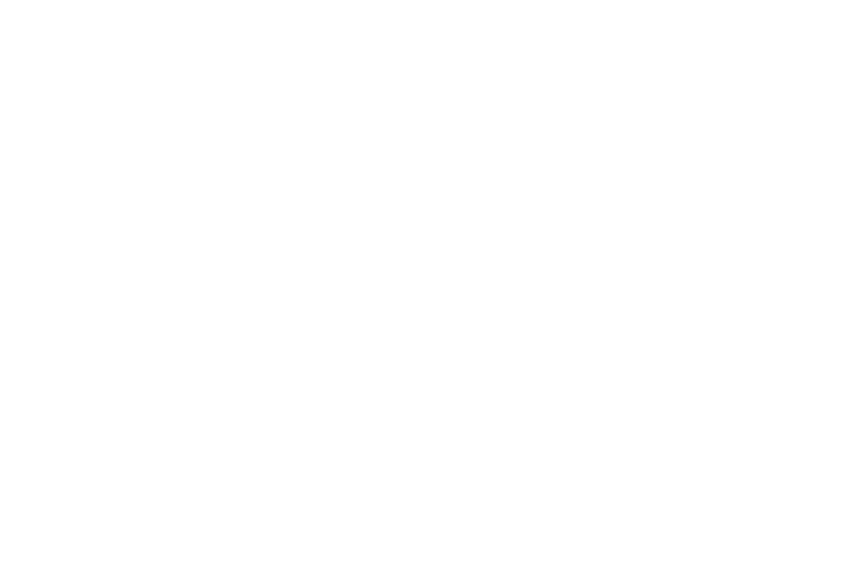

[169.78512916434556, 183.72121594251075, 200.33406549570645, 231, 246.20762639442546, 260.2248670894769, 352.3773653786775, 375, 384.3142747136153, 400.82443534255435, 443.9192207308224, 465.9063290472186, 476, 539.469760427186, 567.4031718190599, 599.2185653407432, 630.1751931892431, 660, 690, 735.3639679381886, 763.7660907824975, 808.5157882283165, 847, 906.8452990768201, 937.8029947315736, 970, 1001.2084971964068, 1033.063678731698, 1064, 1099.409187223624, 1126.6465083986914, 1154.9263764424832, 1156.295429413738, 1165.0614835531378, 1182.7367388017155, 1215, 1245, 1274.139071605583, 1306.1798296141205, 1337, 1373.48822736906, 1418, 1472.118007813442, 1488, 1518.6444354134146, 1526.1435489940486, 1559.2258640882137, 1586.8323710004042]


<IPython.core.display.Javascript object>


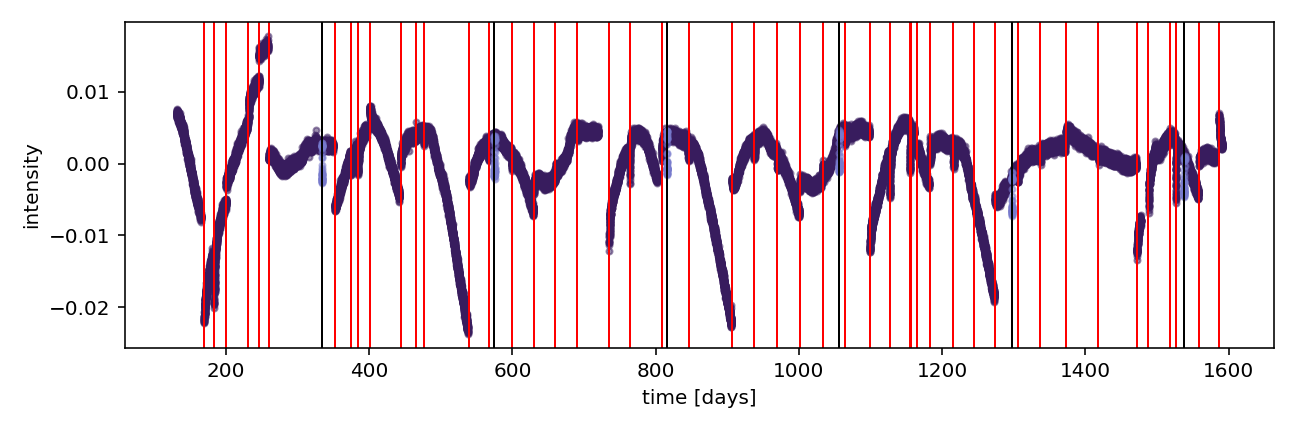

In [145]:
problem_split_x, problem_split_y, problem_split_yerr, problem_split_mask = \
split_around_problems(x, y, yerr, mask, problem_times)
#print(problem_times)


    
#for ii in range(0, len(problem_split_x)):
#    _x, _y = problem_split_x[ii], problem_split_y[ii]
#    plt.plot(_x, _y, 'o', color='k')
#    plt.show()
    

#plot_individual_lc(x[~mask], y[~mask], x[mask], y[mask], t0s, 1./2., period, problem_times)

%matplotlib widget 
plt.connect('motion_notify_event', mouse_move)

print(problem_times)
plot_lc(x[~mask], y[~mask], x[mask], y[mask], t0s, problem_times)



In [31]:
### Special thanks to Michael Hippke for speeding this function up by orders of magnitude!
#@jit(fastmath=True, nopython=True, cache=True)
#@jit
#@jit((float64[:], i8))

def BIC(model, data, errors, nparams):
    chi2 = np.nansum(((model - data) / errors)**2)
    BICval = nparams*np.log(len(data)) + chi2
    return BICval

def polyAM_matrix_gen(times, degree):
    baseline = np.nanmax(times) - np.nanmin(times)
    rows = len(times)
    #cols = 2 * (degree+1) #### this was the CoFiAM formulation 
    cols = (degree+1) #### if degree = 2, you need three columns -- for ax^2 + bx^1 + cx^0
    X_matrix = np.ones(shape=(rows,cols))
    for x in range(rows): ### for each row, that is, for each time!
        for y in range(1, int(cols/2)): #### for each column, up to half the columns -- why?
            #sinarg = (2*np.pi*times[x] * y) / baseline
            #X_matrix[x,y*2] = np.sin(sinarg)
            #X_matrix[x,y*2 + 1] = np.cos(sinarg)
            X_matrix[x,y*2] = times[x]**y #### TRY THIS!
        X_matrix[x,1] = times[x]
    return X_matrix 


def polyAM_matrix_coeffs(times, fluxes, degree):
    assert len(times) > 0
    Xmat = polyAM_matrix_gen(times, degree)
    beta_coefs = np.linalg.lstsq(Xmat, fluxes, rcond=None)[0]
    return Xmat, beta_coefs

### this function spits out the best fit line!
def polyAM_function(times, fluxes, degree):
    input_times = times.astype('f8')
    input_fluxes = fluxes.astype('f8')
    polyAM_matrix, polyAM_coefficients = polyAM_matrix_coeffs(input_times, input_fluxes, degree)
    output = np.matmul(polyAM_matrix, polyAM_coefficients)
    return output 



def polyLOC_matrix_gen(times, degree):
    baseline = np.nanmax(times) - np.nanmin(times)
    rows = len(times)
    #cols = 2 * (degree+1) #### this was the CoFiAM formulation 
    cols = (degree+1) #### if degree = 2, you need three columns -- for ax^2 + bx^1 + cx^0
    X_matrix = np.ones(shape=(rows,cols))
    for x in range(rows): ### for each row, that is, for each time!
        for y in range(1, int(cols/2)): #### for each column, up to half the columns -- why?
            #sinarg = (2*np.pi*times[x] * y) / baseline
            #X_matrix[x,y*2] = np.sin(sinarg)
            #X_matrix[x,y*2 + 1] = np.cos(sinarg)
            X_matrix[x,y*2] = times[x]**y #### TRY THIS!
        X_matrix[x,1] = times[x]
    return X_matrix 


def polyLOC_matrix_coeffs(times, fluxes, degree):
    assert len(times) > 0
    Xmat = polyLOC_matrix_gen(times, degree)
    beta_coefs = np.linalg.lstsq(Xmat, fluxes, rcond=None)[0]
    return Xmat, beta_coefs



### this function spits out the best fit line!
def polyLOC_function(times, fluxes, degree):
    input_times = times.astype('f8')
    input_fluxes = fluxes.astype('f8')
    polyLOC_matrix, polyLOC_coefficients = polyLOC_matrix_coeffs(input_times, input_fluxes, degree)
    output = np.matmul(polyLOC_matrix, polyLOC_coefficients)
    return output 


def polyLOC_iterative(times, fluxes, errors, mask, max_degree=30, min_degree=1):
    ### this function utilizes polyAM_function above, iterates it up to max_degree.
    ### max degree may be calculated using max_order function

    vals_to_min = []
    degs_to_try = np.arange(min_degree,max_degree+1,1)
    BICstats = []

    for deg in degs_to_try:
        output_function = polyAM_function(times[~mask], fluxes[~mask], deg) ### this is the model
        residuals = fluxes[~mask] - output_function
        BICstat = BIC(output_function, fluxes[~mask], errors[~mask], deg+1)
        BICstats.append(BICstat)

    BICstats = np.array(BICstats)

    best_degree = degs_to_try[np.argmin(BICstats)]
    best_BIC = BICstats[np.argmin(np.array(BICstats))]

    ### re-generate the function with the best degree

    best_model = polyLOC_function(times[~mask], fluxes[~mask], best_degree)

    return best_model, best_degree, best_BIC, max_degree 



In [32]:
def local_method(x, y, yerr, mask, t0s, duration, period):
    x_split, y_split, yerr_split, mask_split = split_around_transits(x, y, yerr, mask, t0s, float(6*duration/(24.))/period, period)

    x_no_data_gaps = []
    y_no_data_gaps = []
    yerr_no_data_gaps = []
    mask_no_data_gaps = []

    local_mod = []
    local_mod_all = []
    
    x_all = []
    y_all = []
    yerr_all = []
    mask_all = []
    for ii in range(0, len(x_split)):
        x_i = np.array(x_split[ii])
        y_i = np.array(y_split[ii])
        yerr_i = np.array(yerr_split[ii])
        mask_i = np.array(mask_split[ii])

        x_ii, y_ii, yerr_ii, mask_ii = split_data_gaps(x_i, y_i, yerr_i, mask_i, [599, 1405], t0s)
        x_all.extend(x_ii)
        y_all.extend(y_ii)
        yerr_all.extend(yerr_ii)
        mask_all.extend(mask_ii)
        

        local = polyLOC_iterative(x_ii, y_ii, yerr_ii, mask_ii)


        polyLOC_interp = interp1d(x_ii[~mask_ii], local[0], bounds_error=False, fill_value='extrapolate')
        best_model = polyLOC_interp(x_ii)
        
        local_mod.append(best_model)
        local_mod_all.extend(best_model)
        
        
    
    return np.array(x_all), np.array(y_all), np.array(yerr_all), np.array(mask_all), np.array(local_mod_all)





In [33]:
def DurbinWatson(residuals):
    residual_terms = []
    for nres, res in enumerate(residuals):
        try:
            residual_terms.append(residuals[nres+1] - residuals[nres])
        except:
            pass
    residual_terms = np.array(residual_terms)
    numerator = np.sum(residual_terms**2)
    denominator = np.sum(residuals**2)
    return numerator / denominator


def polyAM_matrix_gen(times, degree):
    baseline = np.nanmax(times) - np.nanmin(times)
    rows = len(times)
    cols = (degree+1) #### if degree = 2, you need 3 columns (including x^0 term)
    X_matrix = np.ones(shape=(rows,cols))
    for x in range(rows): ### for each time
        for y in range(1, int(cols/2)): #### for each column, up to half the columns -- why?
            X_matrix[x,y*2] = times[x]**y #### TRY THIS!
        X_matrix[x,1] = times[x]
    return X_matrix 


def polyAM_matrix_coeffs(times, fluxes, degree):
    assert len(times) > 0
    Xmat = polyAM_matrix_gen(times, degree)
    beta_coefs = np.linalg.lstsq(Xmat, fluxes, rcond=None)[0]
    return Xmat, beta_coefs



### this function spits out the best fit line!
def polyAM_function(times, fluxes, degree):
    input_times = times.astype('f8')
    input_fluxes = fluxes.astype('f8')
    polyAM_matrix, polyAM_coefficients = polyAM_matrix_coeffs(input_times, input_fluxes, degree)
    output = np.matmul(polyAM_matrix, polyAM_coefficients)
    return output 


def polyAM_iterative(times, fluxes, mask, max_degree=20, min_degree=1):
    ### this function utilizes polyAM_function above, iterates it up to max_degree.

    vals_to_minimize = []
    degs_to_try = np.arange(min_degree, max_degree+1,1)
    DWstats = []

    for deg in degs_to_try:
        output_function = polyAM_function(times[~mask], fluxes[~mask], deg)

        residuals = fluxes[~mask] - output_function

        DWstat = DurbinWatson(residuals)
        DWstats.append(DWstat)

        val_to_minimize = (DWstat - 2)**2
        vals_to_minimize.append(val_to_minimize)

    best_degree = degs_to_try[np.argmin(np.array(vals_to_minimize))]
    best_DW = DWstats[np.argmin(np.array(vals_to_minimize))]

    ### re-generate the function with the best degree

    best_model = polyAM_function(times[~mask], fluxes[~mask], best_degree)

    return best_model, best_degree, best_DW, max_degree 


In [86]:
def polynomial_method(x, y, yerr, mask, t0s, duration, period, problem_times = None):
    
    '''
    x_split, y_split, yerr_split, mask_split = split_around_transits(x, y, yerr, mask, t0s, float(6*duration/(24.))/period, period)

    x_no_data_gaps = []
    y_no_data_gaps = []
    yerr_no_data_gaps = []
    mask_no_data_gaps = []


    
    x_all = []
    y_all = []
    yerr_all = []
    mask_all = []
    for ii in range(0, len(x_split)):
        x_i = np.array(x_split[ii])
        y_i = np.array(y_split[ii])
        yerr_i = np.array(yerr_split[ii])
        mask_i = np.array(mask_split[ii])

        x_ii, y_ii, yerr_ii, mask_ii = split_data_gaps(x_i, y_i, yerr_i, mask_i, [599, 1405], t0s)
        x_all.extend(x_ii)
        y_all.extend(y_ii)
        yerr_all.extend(yerr_ii)
        mask_all.extend(mask_ii)
        
    '''
    
     
    if problem_times == None:
        problem_times = find_problem_times(x, y, t0s, duration)
    print(problem_times)
    problem_split_x, problem_split_y, problem_split_yerr, problem_split_mask = \
    split_around_problems(x, y, yerr, mask, problem_times)
    
    #for ii in range(0, len(problem_split_x)):
    #    _x, _y = problem_split_x[ii], problem_split_y[ii]
    #    plt.plot(_x, _y, 'o', color='k')
    #    plt.show()
    
    poly_mod = []
    poly_mod_all = []
    
    x_all = []
    y_all = []
    yerr_all = []
    mask_all = []

    for ii in range(0, len(problem_split_x)):
        x_ii = problem_split_x[ii]
        y_ii = problem_split_y[ii]
        yerr_ii = problem_split_yerr[ii]
        mask_ii = problem_split_mask[ii]
        
        
        
        print(x_ii)
        poly = polyAM_iterative(x_ii, y_ii, mask_ii, max_degree=30)


        poly_interp = interp1d(x_ii[~mask_ii], poly[0], bounds_error=False, fill_value='extrapolate')
        best_model = poly_interp(x_ii)
        
        plt.plot(x_ii, y_ii, 'o', color ='k')
        plt.plot(x_ii, best_model, 'o', color ='b')
        [plt.axvline(_x, linewidth=1, color='r') for _x in problem_times]
        plt.xlim(np.min(x_ii)-5,np.max(x_ii)+5) 

        plt.show()

        plt.plot(x_ii, (y_ii+1)/(best_model+1)-1, 'o', color ='k')
        plt.xlim(np.min(x_ii)-5,np.max(x_ii)+5) 
        plt.show()
        
        poly_mod.append(best_model)
        poly_mod_all.extend(best_model)
        
        x_all.extend(x_ii)
        y_all.extend(y_ii)
        yerr_all.extend(yerr_ii)
        mask_all.extend(mask_ii)
    return np.array(x_all), np.array(y_all), np.array(yerr_all), np.array(mask_all), np.array(poly_mod_all)




In [52]:
def gp_method(x, y, yerr, mask, t0s, duration, period):
    
    '''
    x_split, y_split, yerr_split, mask_split = split_around_transits(x, y, yerr, mask, t0s, float(6*duration/(24.))/period, period)

    x_no_data_gaps = []
    y_no_data_gaps = []
    yerr_no_data_gaps = []
    mask_no_data_gaps = []

    gp_mod = []
    gp_mod_all = []
    
    x_all = []
    y_all = []
    yerr_all = []
    mask_all = []
    
    for ii in range(0, len(x_split)):
        
        x_i = np.array(x_split[ii])
        y_i = np.array(y_split[ii])
        yerr_i = np.array(yerr_split[ii])
        mask_i = np.array(mask_split[ii])

        x_ii, y_ii, yerr_ii, mask_ii = split_data_gaps(x_i, y_i, yerr_i, mask_i, [599, 1405], t0s)
        x_all.extend(x_ii)
        y_all.extend(y_ii)
        yerr_all.extend(yerr_ii)
        mask_all.extend(mask_ii)
        

        print('running gp fit on ' + str(ii+1) +'th transit')
        print('')
        print('trying GP1')
        print('')
        print('')
        print('')
        
        '''
    
    problem_times = find_problem_times(x, y, t0s, duration)
    problem_split_x, problem_split_y, problem_split_yerr, problem_split_mask = \
    split_around_problems(x, y, yerr, mask)
    
    #for ii in range(0, len(problem_split_x)):
    #   _x, _y = problem_split_x[ii], problem_split_y[ii]
    #    plt.plot(_x, _y, 'o', color='k')
    #    plt.show()
    gp_mod = []
    gp_mod_all = []
    
    x_all = []
    y_all = []
    yerr_all = []
    mask_all = []
    for ii in range(0, len(problem_split_x)):
        x_ii = problem_split_x[ii]
        y_ii = problem_split_y[ii]
        yerr_ii = problem_split_yerr[ii]
        mask_ii = problem_split_mask[ii]
        

        gp_model1 = gp1(x_ii[~mask_ii], y_ii[~mask_ii], yerr_ii[~mask_ii], x_ii)
        logp1 = gp_model1[0].check_test_point(test_point=gp_model1[1]).sum(axis = 0)
        
        print('trying GP2')
        print('')
        print('')
        
        gp_model2 = gp2(x_ii[~mask_ii], y_ii[~mask_ii], yerr_ii[~mask_ii], x_ii)
        logp2 = gp_model2[0].check_test_point(test_point=gp_model2[1]).sum(axis = 0)
        
        
        if logp1 > logp2:
            gp_model = gp_model1[1]['pred']
            
        else:
            gp_model = gp_model2[1]['pred']
        
        gp_mod.append(gp_model)
        gp_mod_all.extend(gp_model)
        
        
        x_all.extend(x_ii)
        y_all.extend(y_ii)
        yerr_all.extend(yerr_ii)
        mask_all.extend(mask_ii)


        
    return np.array(x_all), np.array(y_all), np.array(yerr_all), np.array(mask_all), np.array(gp_mod_all)




In [36]:
#kepler 1513 = koi-3678
time_star, lc_star, lc_err_star, \
time_transit, lc_transit, lc_err_transit, \
t0s, period, duration, mask = get_light_curve('koi-3762', 'sap_flux', Kepler=True)

sap_x, sap_y, sap_yerr = recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star)

sap_x_all, sap_y_all, sap_yerr_all, sap_mask_all, sap_local_mod = \
local_method(sap_x, sap_y, sap_yerr, mask, t0s, duration, period)

Exoplanet Archive: Planet Comparison Table
------------------------------------------

            tic_id      t0 [BJD]  period [days]  duration [hours]
884  TIC 351191596  2.455167e+06      240.79894            16.442


In [37]:
#kepler 1513 = koi-3678
time_star, lc_star, lc_err_star, \
time_transit, lc_transit, lc_err_transit, \
t0s, period, duration, mask = get_light_curve('koi-3762', 'pdcsap_flux', Kepler=True)

pdcsap_x, pdcsap_y, pdcsap_yerr = recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star)

pdcsap_x_all, pdcsap_y_all, pdcsap_yerr_all, pdcsap_mask_all, pdcsap_local_mod = \
local_method(pdcsap_x, pdcsap_y, pdcsap_yerr, mask, t0s, duration, period)

Exoplanet Archive: Planet Comparison Table
------------------------------------------

            tic_id      t0 [BJD]  period [days]  duration [hours]
884  TIC 351191596  2.455167e+06      240.79894            16.442


In [38]:
def remove_trim_times(x, y, yerr, trim_times):
    
    for trim in trim_times:
        trim_min = find_nearest(x, trim[0]) 
        trim_max = find_nearest(x, trim[1]) 
        
        index_min = int(np.where(x == trim_min)[0])
        index_max = int(np.where(x == trim_max)[0])
        
        indices = np.arange(index_min, index_max)

        
        x = np.delete(x, indices)
        y = np.delete(y, indices)
        yerr = np.delete(yerr, indices)
        
    return x, y, yerr


In [136]:
print(trim_times)
print()

[[372, 375], [845, 847]]


Exoplanet Archive: Planet Comparison Table
------------------------------------------

            tic_id      t0 [BJD]  period [days]  duration [hours]
884  TIC 351191596  2.455167e+06      240.79894            16.442
ERROR, DIDN'T FIND PROBLEM TIME WITHIN 1 DAY OF INPUT
ERROR, DIDN'T FIND PROBLEM TIME WITHIN 1 DAY OF INPUT
ERROR, DIDN'T FIND PROBLEM TIME WITHIN 1 DAY OF INPUT
ERROR, DIDN'T FIND PROBLEM TIME WITHIN 1 DAY OF INPUT
ERROR, DIDN'T FIND PROBLEM TIME WITHIN 1 DAY OF INPUT
ERROR, DIDN'T FIND PROBLEM TIME WITHIN 1 DAY OF INPUT
[169.78512916434556, 183.72121594251075, 200.33406549570645, 230.2899483198198, 230.2899483198198, 230.2899483198198, 230.2899483198198, 230.2899483198198, 230.2899483198198, 230.2899483198198, 246.20762639442546, 260.2248670894769, 320.99249292775494, 320.99249292775494, 320.99249292775494, 320.99249292775494, 320.99249292775494, 320.99249292775494, 320.99249292775494, 352.3773653786775, 374.99673397249717, 374.99673397249717, 374.99673397249717, 374.9

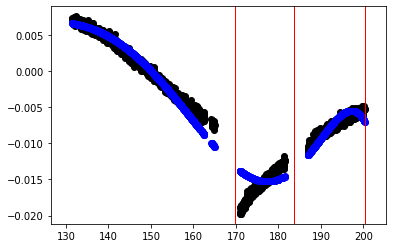

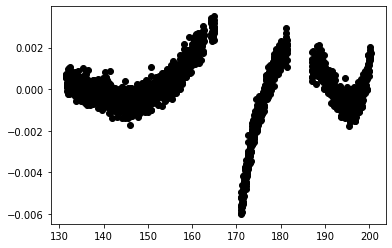

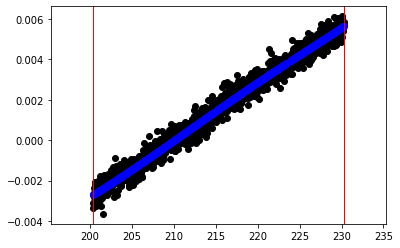

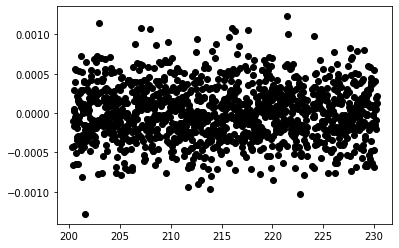

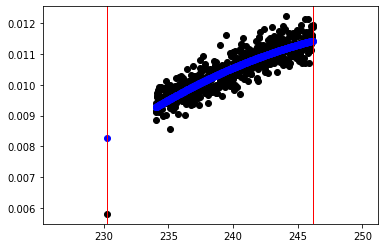

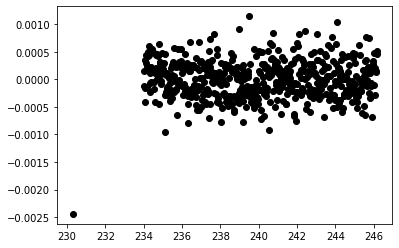

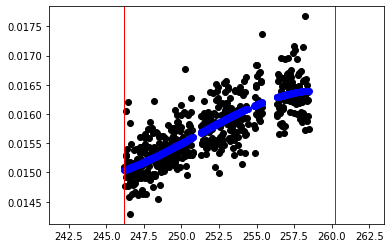

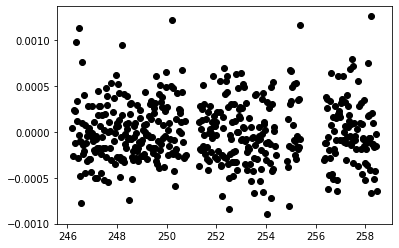

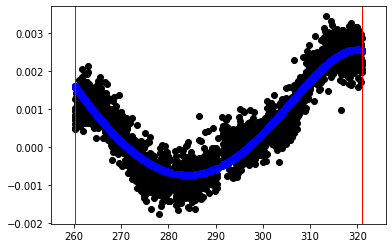

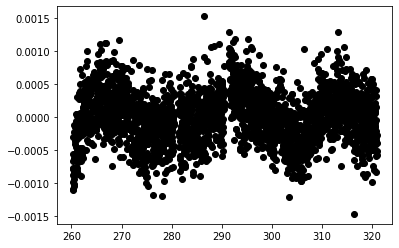

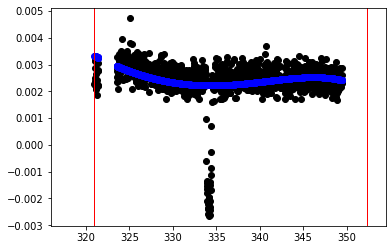

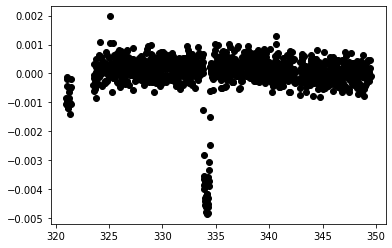

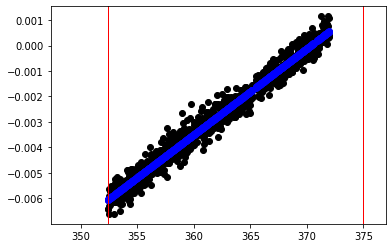

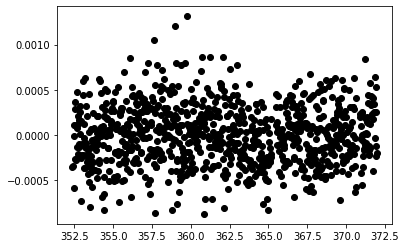

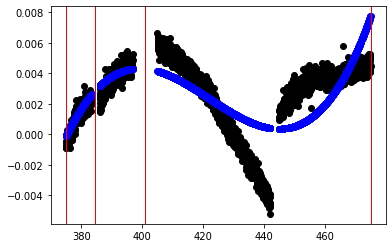

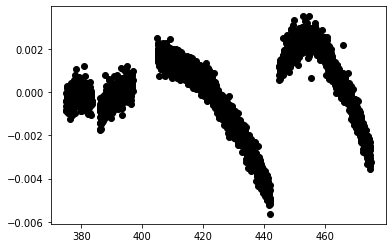

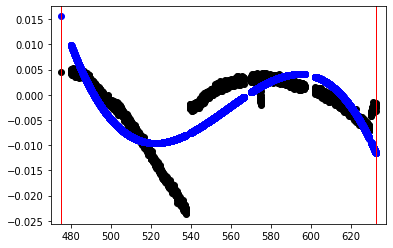

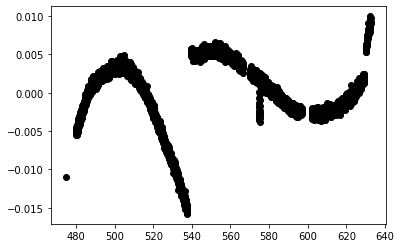

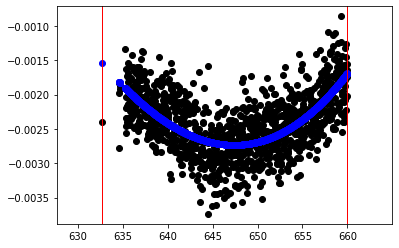

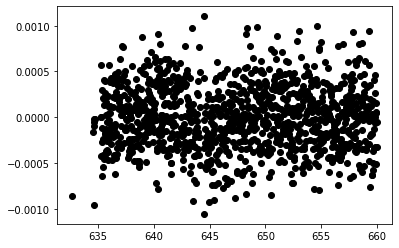

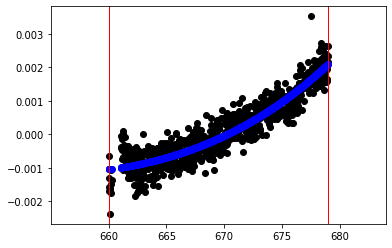

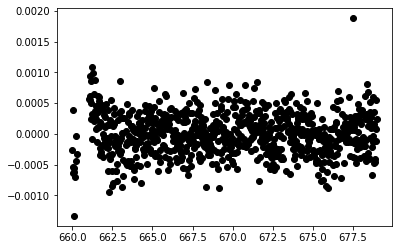

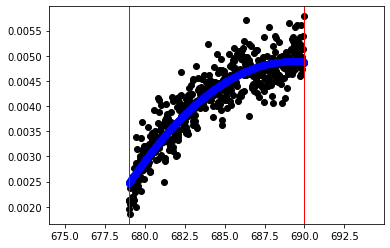

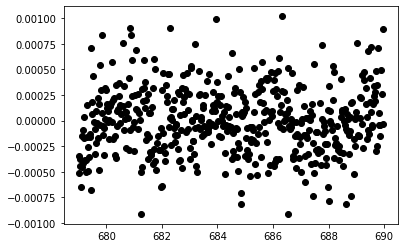

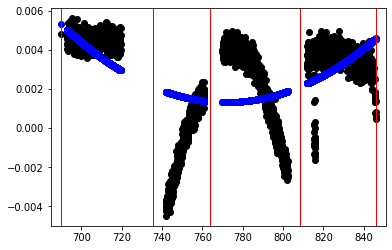

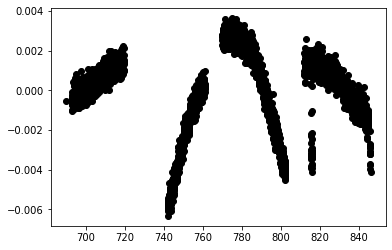

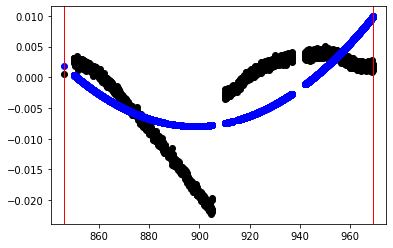

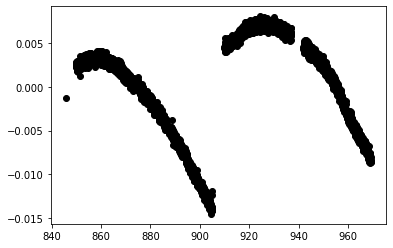

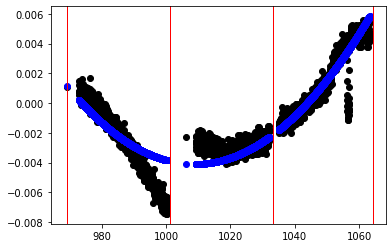

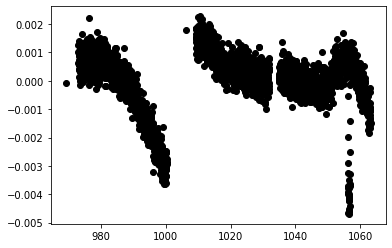

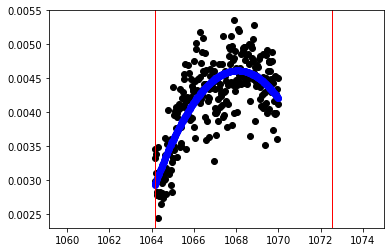

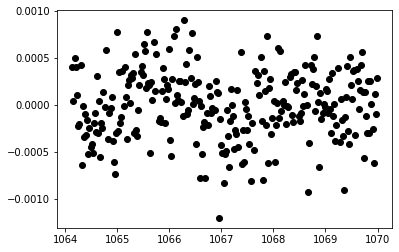

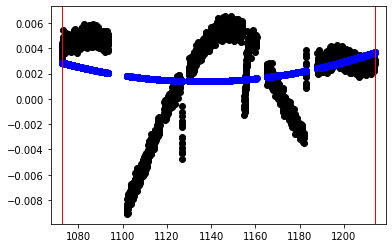

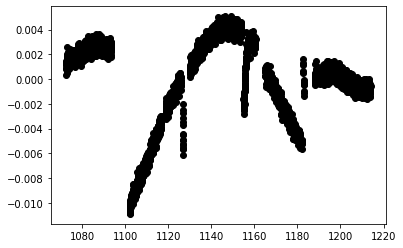

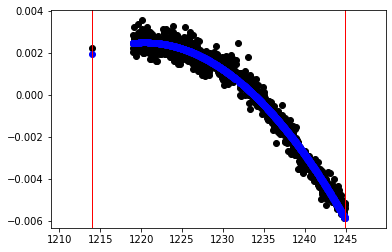

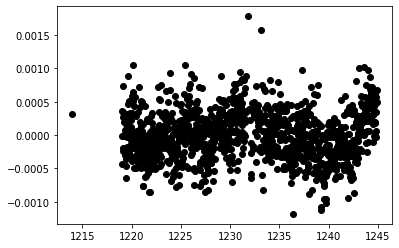

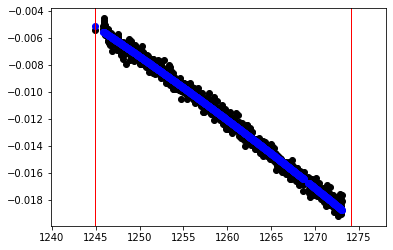

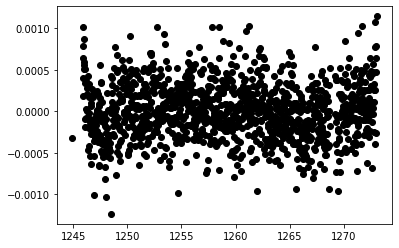

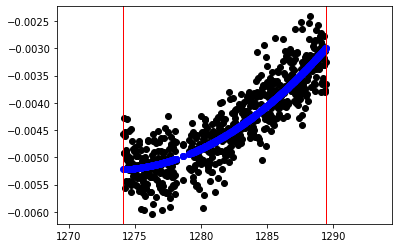

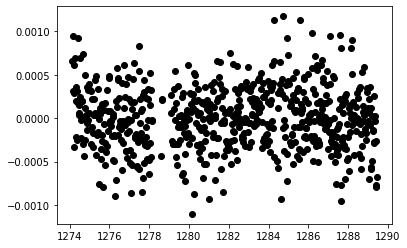

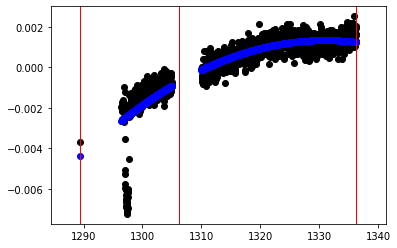

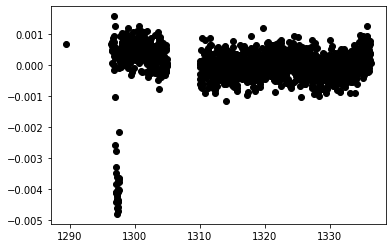

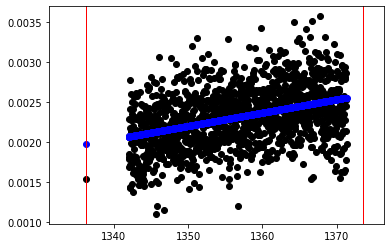

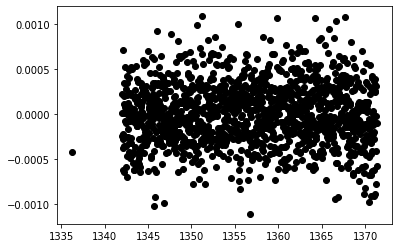

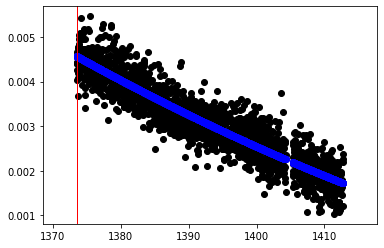

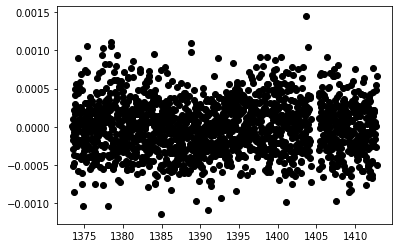

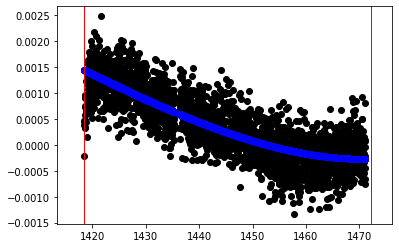

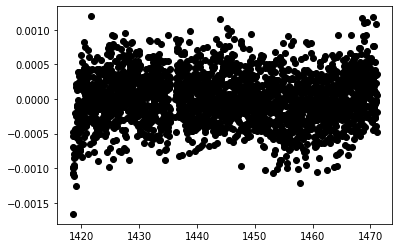

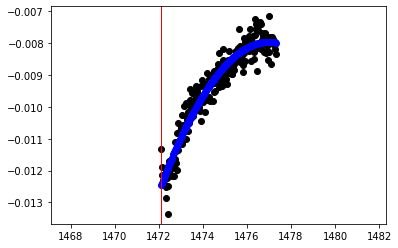

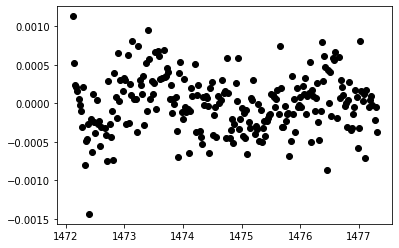

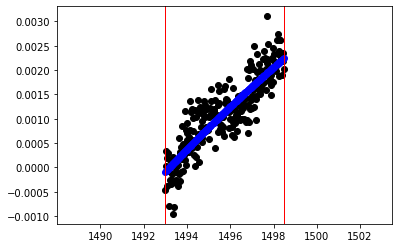

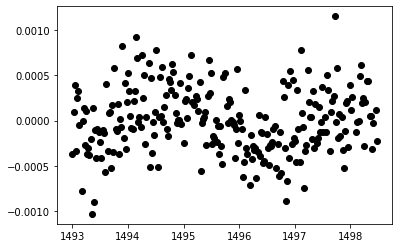

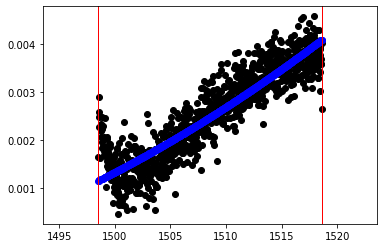

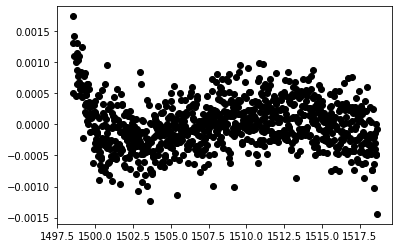

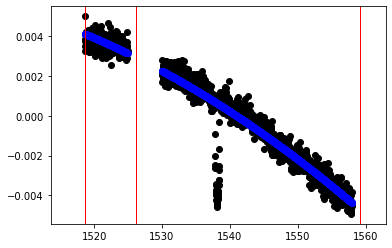

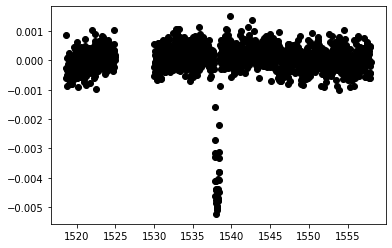

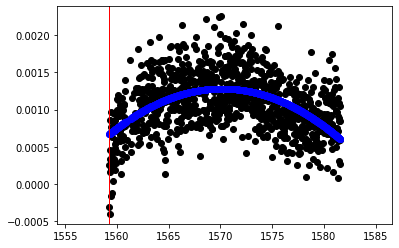

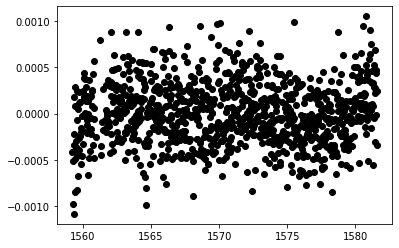

In [74]:
#kepler 1513 = koi-3678
%matplotlib inline

time_star, lc_star, lc_err_star, \
time_transit, lc_transit, lc_err_transit, \
t0s, period, duration, mask = get_light_curve('koi-3762', 'sap_flux', Kepler=True)

sap_x, sap_y, sap_yerr = recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star)
sap_x, sap_y, sap_yerr = remove_trim_times(sap_x, sap_y, sap_yerr, trim_times)
problem_times = modify_problem_times(sap_x, problem_times, a_prob_time, not_a_prob_time)
#print(problem_times)
#print(trim_times)
sap_x_all, sap_y_all, sap_yerr_all, sap_mask_all, sap_poly_mod = \
polynomial_method(sap_x, sap_y, sap_yerr, mask, t0s, duration, period, problem_times=problem_times)

Exoplanet Archive: Planet Comparison Table
------------------------------------------

            tic_id      t0 [BJD]  period [days]  duration [hours]
884  TIC 351191596  2.455167e+06      240.79894            16.442
[455.26012879334303, 465.9063290472186, 507.9601118946812, 516.5629632537457, 677.518493534415, 888.9449012606638, 905.0062498251573, 1156.2749956843982, 1156.295429413738, 1518.6444354134146]
[131.5117196  131.53215404 131.55258837 ... 455.17839241 455.19882643
 455.21926065]


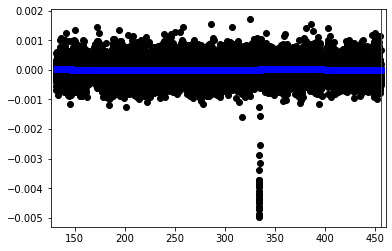

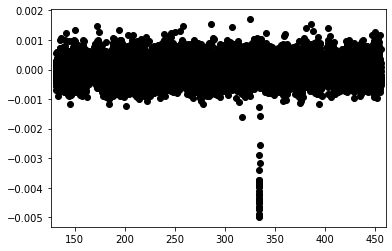

[455.26012879 455.28056302 455.30099704 455.32143116 455.34186538
 455.36229941 455.38273353 455.40316775 455.42360178 455.4440359
 455.46447012 455.48490425 455.50533827 455.5257724  455.54620662
 455.56664064 455.58707477 455.60750899 455.62794302 455.64837714
 455.66881137 455.6892454  455.70967952 455.73011375 455.75054777
 455.7709819  455.79141613 455.81185025 455.83228428 455.85271851
 455.87315264 455.89358666 455.91402089 455.93445502 455.95488905
 455.9957574  456.01619143 456.03662566 456.05705979 456.07749382
 456.09792805 456.11836208 456.13879621 456.15923034 456.17966447
 456.2000986  456.22053273 456.26140099 456.28183512 456.30226935
 456.32270338 456.34313751 456.36357174 456.38400578 456.40443991
 456.42487414 456.44530817 456.4657423  456.48617654 456.50661067
 456.5270447  456.54747894 456.56791307 456.5883471  456.60878134
 456.62921547 456.6496495  456.67008374 456.69051787 456.71095191
 456.73138614 456.77225431 456.79268845 456.83355672 456.85399085
 456.874425

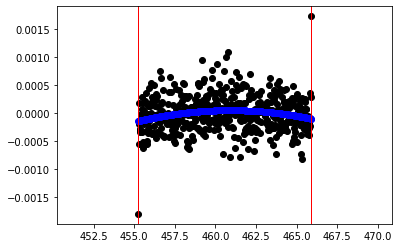

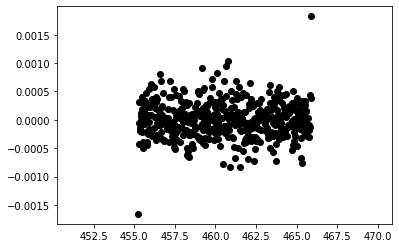

[465.90632905 465.92676335 465.94719756 ... 507.89880891 507.91924334
 507.93967767]


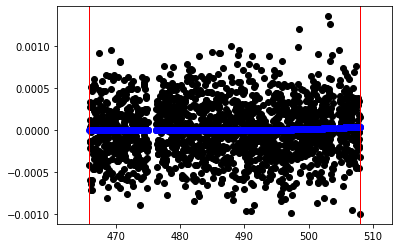

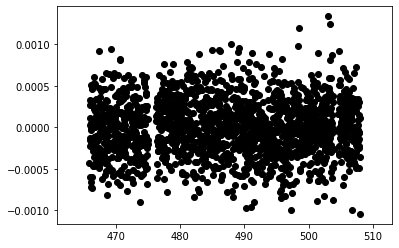

[507.96011189 507.98054632 508.00098065 508.02141498 508.04184931
 508.06228364 508.08271797 508.1031523  508.12358663 508.14402096
 508.16445539 508.18488962 508.20532395 508.22575838 508.24619261
 508.26662694 508.28706136 508.30749559 508.34836435 508.36879858
 508.38923301 508.40966734 508.43010167 508.450536   508.47097033
 508.49140466 508.51183898 508.53227331 508.55270764 508.57314197
 508.5935763  508.61401053 508.63444496 508.65487929 508.67531372
 508.69574794 508.71618227 508.7366167  508.75705093 508.77748526
 508.79791969 508.81835392 508.83878824 508.85922267 508.8796569
 508.90009123 508.92052566 508.94095989 508.96139422 508.98182864
 509.00226297 509.04313163 509.06356596 509.08400028 509.10443461
 509.12486894 509.14530337 509.1657376  509.18617193 509.20660635
 509.22704058 509.24747491 509.26790924 509.28834357 509.30877789
 509.32921222 509.34964655 509.37008098 509.3905152  509.41094953
 509.43138396 509.45181819 509.47225252 509.55398993 509.57442425
 509.594858

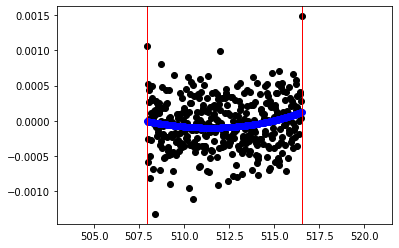

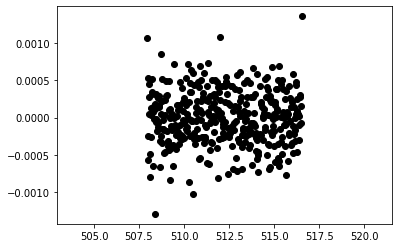

[516.56296325 516.58339757 516.60383198 ... 677.45719487 677.47762783
 677.49806058]


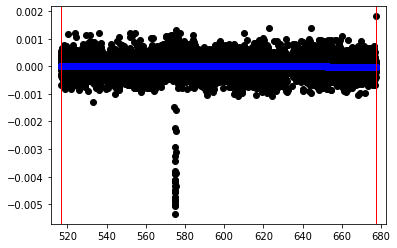

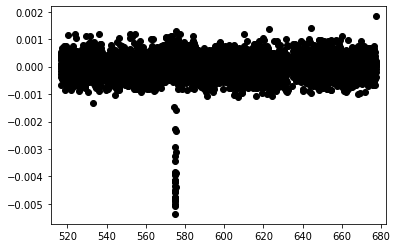

[677.51849353 677.53892629 677.55935914 ... 888.8427296  888.88359833
 888.90403254]


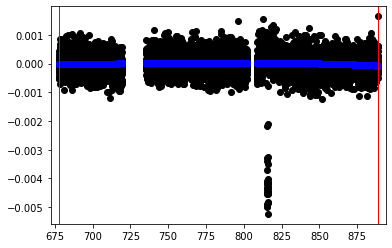

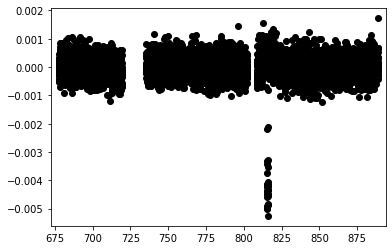

[888.94490126 888.96533567 889.00620419 889.02663861 889.04707282
 889.06750713 889.08794154 889.10837585 889.12881006 889.16967878
 889.19011309 889.2105474  889.23098162 889.25141603 889.27185034
 889.29228455 889.31271896 889.33315327 889.35358748 889.37402189
 889.3944562  889.41489041 889.43532482 889.45575913 889.47619354
 889.49662775 889.51706206 889.53749647 889.55793068 889.57836499
 889.5987994  889.61923371 889.63966792 889.66010233 889.68053664
 889.70097084 889.72140525 889.74183956 889.76227397 889.78270818
 889.80314249 889.8235769  889.84401111 889.86444532 889.88487973
 889.90531403 889.92574824 889.94618265 889.96661696 889.98705137
 890.00748558 890.02791988 890.04835429 890.0687885  890.08922281
 890.10965722 890.13009153 890.15052573 890.17096014 890.21182866
 890.23226306 890.25269737 890.27313178 890.29356599 890.3140003
 890.3344347  890.35486891 890.37530322 890.39573762 890.41617183
 890.43660614 890.45704055 890.47747475 890.49790906 890.51834337
 890.538777

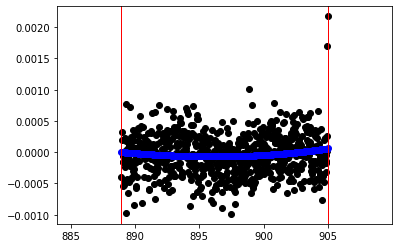

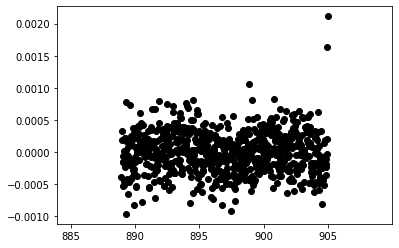

[ 905.00624983  905.02668407  905.04711831 ... 1156.2136948  1156.23412853
 1156.25456206]


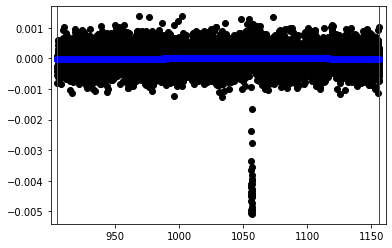

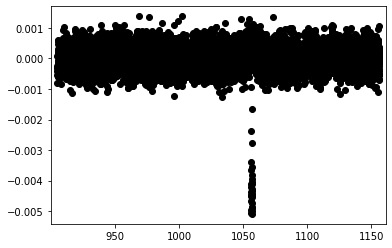

[1156.27499568]


<ipython-input-33-853df45d085d>:11: RuntimeWarning: invalid value encountered in double_scalars
  return numerator / denominator


ValueError: x and y arrays must have at least 2 entries

In [87]:
#kepler 1513 = koi-3678
time_star, lc_star, lc_err_star, \
time_transit, lc_transit, lc_err_transit, \
t0s, period, duration, mask = get_light_curve('koi-3762', 'pdcsap_flux', Kepler=True)

pdcsap_x, pdcsap_y, pdcsap_yerr = recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star)

pdcsap_x_all, pdcsap_y_all, pdcsap_yerr_all, pdcsap_mask_all, pdcsap_poly_mod = \
polynomial_method(pdcsap_x, pdcsap_y, pdcsap_yerr, mask, t0s, duration, period)

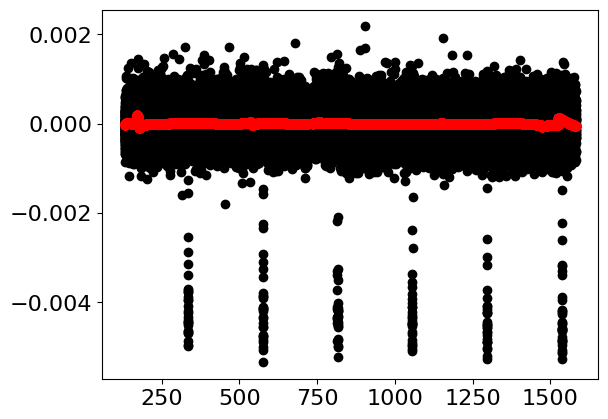

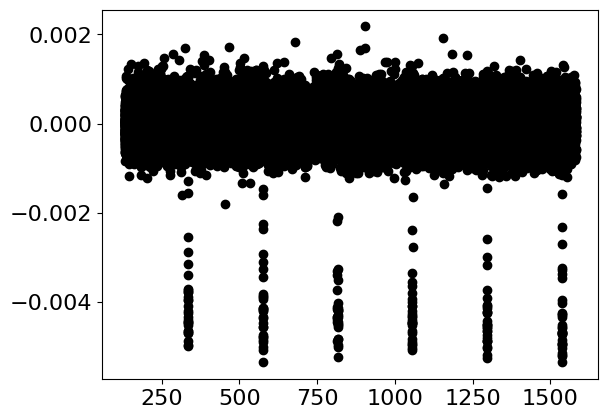

In [50]:
plt.plot(pdcsap_x_all, pdcsap_y_all, 'o', color ='k')
plt.plot(pdcsap_x_all, pdcsap_poly_mod, 'o', color ='r')
plt.show()

plt.plot(pdcsap_x_all, (pdcsap_y_all+1)/(pdcsap_poly_mod+1)-1, 'o', color ='k')
plt.show()

In [854]:
#kepler 1513 = koi-3678
time_star, lc_star, lc_err_star, \
time_transit, lc_transit, lc_err_transit, \
t0s, period, duration, mask = get_light_curve('kepler 1513', 'pdcsap_flux', Kepler=True)

pdcsap_x, pdcsap_y, pdcsap_yerr = recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star)

pdcsap_x_all, pdcsap_y_all, pdcsap_yerr_all, pdcsap_mask_all, pdcsap_gp_mod = \
gp_method(pdcsap_x, pdcsap_y, pdcsap_yerr, mask, t0s, duration, period)

Exoplanet Archive: Planet Comparison Table
------------------------------------------

            tic_id      t0 [BJD]  period [days]  duration [hours]
921  TIC 394177315  2.455111e+06     160.884651           10.7536


optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 79962.82589066974 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


trying GP2




optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 197793.2177850362 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


NameError: name 'gp_mod_all' is not defined

In [565]:
#kepler 1513 = koi-3678
time_star, lc_star, lc_err_star, \
time_transit, lc_transit, lc_err_transit, \
t0s, period, duration, mask = get_light_curve('kepler 1513', 'sap_flux', Kepler=True)

sap_x, sap_y, sap_yerr = recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star)

sap_x_all, sap_y_all, sap_yerr_all, sap_mask_all, sap_gp_mod = \
gp_method(sap_x, sap_y, sap_yerr, mask, t0s, duration, period)

Exoplanet Archive: Planet Comparison Table
------------------------------------------

            tic_id      t0 [BJD]  period [days]  duration [hours]
921  TIC 394177315  2.455111e+06     160.884651           10.7536
running gp fit on 1th transit

trying GP1





optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, mean]


message: Optimization terminated successfully.
logp: 253.35968219439104 -> 818.9294554520753


trying GP2




optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, mean]


message: Optimization terminated successfully.
logp: 504.05490654802054 -> 892.8177407790524





running gp fit on 2th transit

trying GP1





optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, mean]


message: Optimization terminated successfully.
logp: 205.62440945597933 -> 696.3419626515845


trying GP2




optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, mean]


message: Optimization terminated successfully.
logp: 374.6549106452197 -> 767.6651844669012





running gp fit on 3th transit

trying GP1





optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 95.75130126597338 -> 752.9746527826727


trying GP2




optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 152.65374503031472 -> 833.178184773907





running gp fit on 4th transit

trying GP1





optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 154.38362852359333 -> 666.2825064874721


trying GP2




optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, mean]


message: Optimization terminated successfully.
logp: 290.2439580952296 -> 743.6658367006864





running gp fit on 5th transit

trying GP1





optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, mean]


message: Optimization terminated successfully.
logp: 252.59642630520443 -> 658.6317048299559


trying GP2




optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, mean]


message: Optimization terminated successfully.
logp: 460.7178805406429 -> 723.7554303691913





running gp fit on 6th transit

trying GP1





optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, mean]


message: Optimization terminated successfully.
logp: 264.44846204481865 -> 861.9268895442591


trying GP2




optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, mean]


message: Optimization terminated successfully.
logp: 525.8417961724376 -> 936.6262032048699





running gp fit on 7th transit

trying GP1





optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 216.76544695090388 -> 1004.5662481239801


trying GP2




optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 427.36783685555866 -> 1091.3168312405783





running gp fit on 8th transit

trying GP1





optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 97.0628576865009 -> 845.4711104848286


trying GP2




optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 152.2361916779298 -> 932.0875303072326





running gp fit on 9th transit

trying GP1





optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 255.6723094367102 -> 1297.4567119702238


trying GP2




optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 527.7700258818279 -> 1385.8103260187584


In [73]:
def get_detrended_lc(y, detrending_model):
    '''
    input:
    y = light curve
    detrending model = stellar detrending model evaluated at same time as fluxes
    
    returns:
    detrended_lc = detrended light curve evaluated at same time as fluxes
    
    '''
    detrended_lc = (((y + 1) / (detrending_model + 1)) - 1)
    
    return np.array(detrended_lc)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans


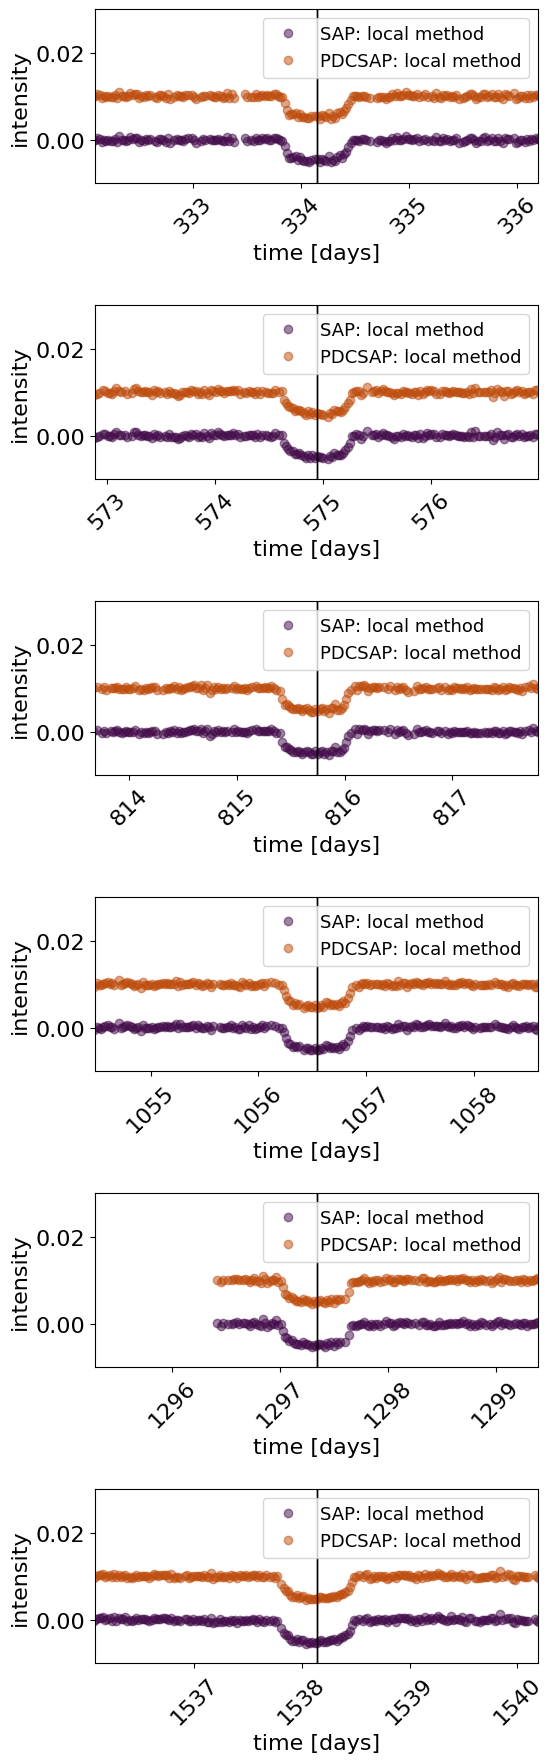

In [77]:
sap_local_detrended = get_detrended_lc(sap_y_all, sap_local_mod)
pdcsap_local_detrended = get_detrended_lc(pdcsap_y_all, pdcsap_local_mod)
#sap_gp_detrended = get_detrended_lc(sap_y_all, sap_gp_mod)
#pdcsap_gp_detrended = get_detrended_lc(pdcsap_y_all, pdcsap_gp_mod)
#sap_poly_detrended = get_detrended_lc(sap_y_all, sap_poly_mod)
#pdcsap_poly_detrended = get_detrended_lc(pdcsap_y_all, pdcsap_poly_mod)

y_detrended = [sap_local_detrended, pdcsap_local_detrended]
               #sap_gp_detrended, pdcsap_gp_detrended,
               #sap_poly_detrended, pdcsap_poly_detrended]


if sap_x_all.all() == pdcsap_x_all.all():
    x_detrended = sap_x_all
    
if sap_yerr_all.all() == pdcsap_yerr_all.all():
    yerr_detrended = sap_yerr_all
    
if sap_mask_all.all() == pdcsap_mask_all.all():
    mask_detrended = sap_mask_all

    

plot_detrended_lc(x_detrended, y_detrended,
                  ['SAP: local method', 'PDCSAP: local method'],
                   #'SAP: GP', 'PDCSAP: GP', 
                   #'SAP: polynomial method', 'PDCSAP: polynomial method'],
                  t0s, float(3*duration/(24.))/period, period,
                  ["#430b4a", "#be4b0b"],# "#21b0ff", "#b1005f", "#014aa2", "#d974e7"],
                  figname = './figures/koi3678_local.pdf'
)





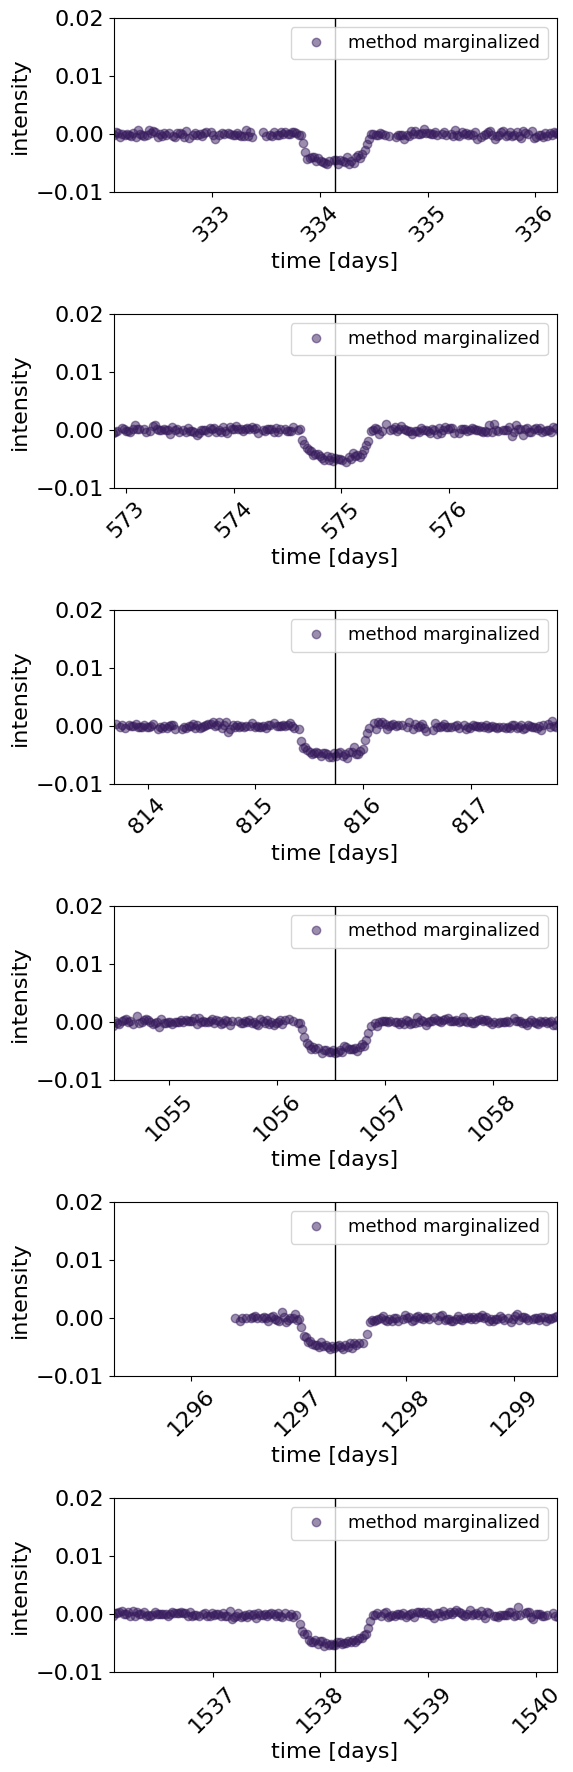

In [78]:
#y_detrended = [sap_local_detrended, pdcsap_local_detrended,
#               sap_gp_detrended, pdcsap_gp_detrended]

y_detrended = np.array(y_detrended)
y_detrended_transpose = y_detrended.T

method_marg_detrended = np.median(y_detrended_transpose, axis=1)

plot_detrended_lc(x_detrended, [method_marg_detrended],
                  ['method marginalized'],
                  t0s, float(3*duration/(24.))/period, period,
                  ["#381c5e"],
                  figname = './figures/koi3678_method_marg.pdf'
)



In [58]:
# 0.01 days ~ .24 hours
# 11 points...as long as its not longer than transit time-scale (t_window << t_transit)
#(maybe do 2 step process (one on masked data and then one on phase folded in transit))
moving_median_data = moving_median(x, y, yerr, mask, 0.01, 10)

x = moving_median_data[0]
y = moving_median_data[1]
yerr = moving_median_data[2]
mask = moving_median_data[3]


moving_med = moving_median_data[5]

TypeError: moving_median() takes 5 positional arguments but 6 were given

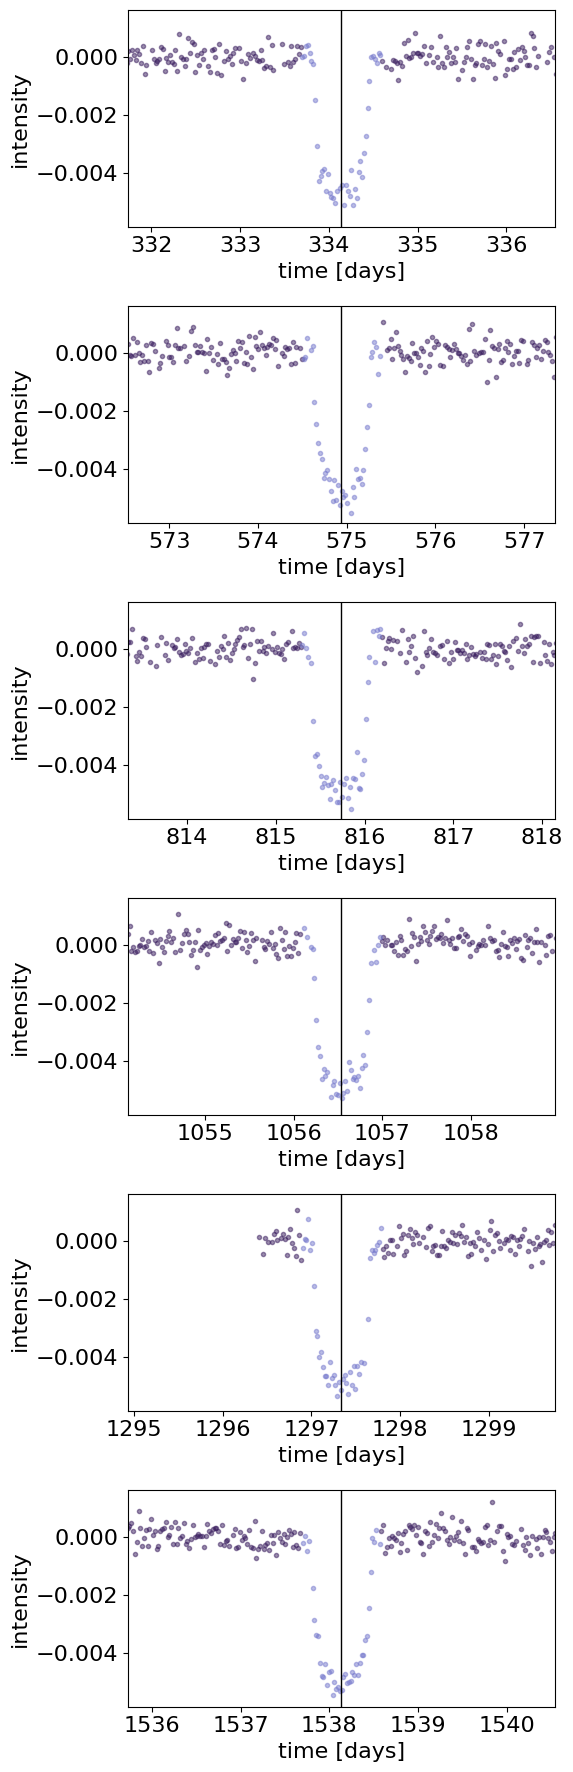

In [79]:
x, y, yerr, mask = np.array(x_detrended), np.array(method_marg_detrended), np.array(yerr_detrended), np.array(mask_detrended)

plot_individual_lc(x[~mask], y[~mask], x[mask], y[mask], t0s, .01, period, [])

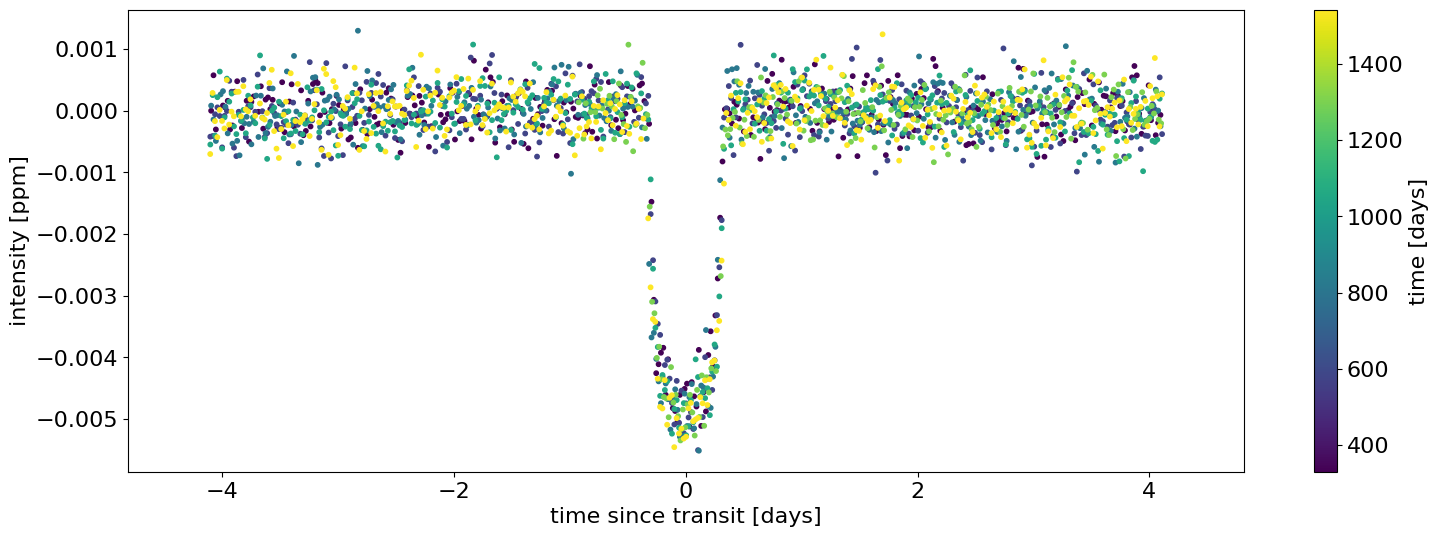

In [80]:
plot_phase_fold_lc(x_detrended, method_marg_detrended, period, t0s, 50)

## Transit search

Now, let's use [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/timeseries/bls.html)
(Note: you'll need AstroPy v3.1 or more recent to use this feature) to estimate the period, phase, and depth of the transit.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans


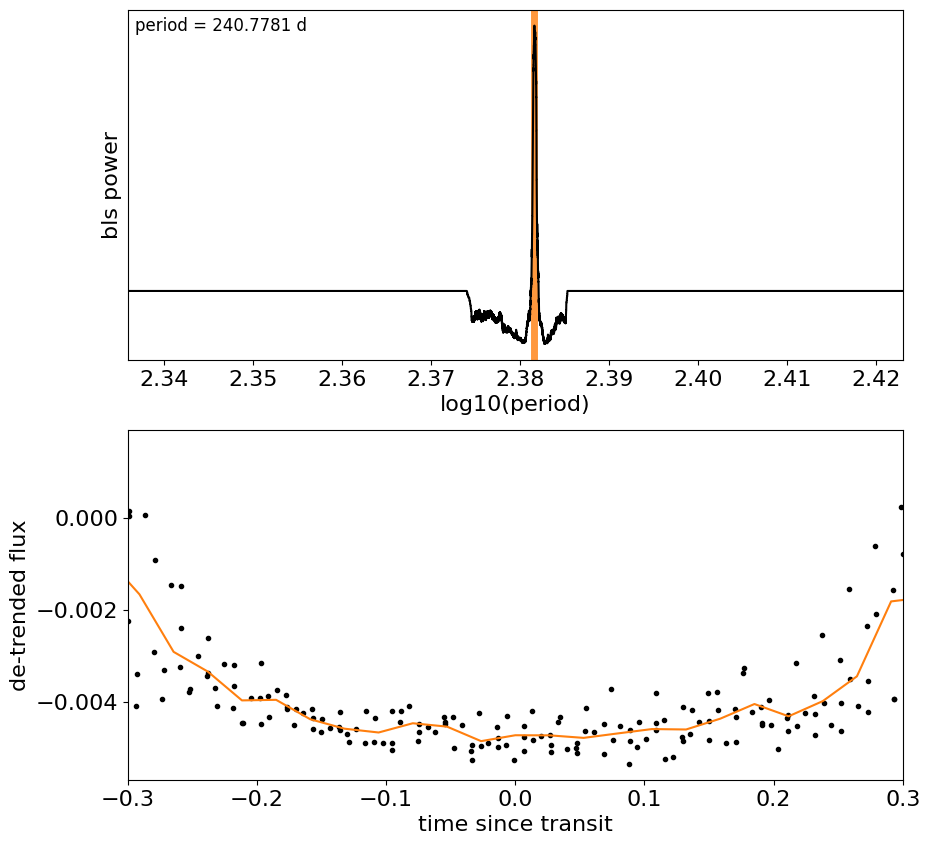

In [81]:
x, y, yerr = pdcsap_x_all, pdcsap_y_all, pdcsap_yerr_all

from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(period[0]-.1*period[0]), np.log(period[0]+.1*period[0]), 50000))

bls = BoxLeastSquares(x, y)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(x, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.4f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (x - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold, y, ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux")
_ = ax.set_xlabel("time since transit")

## The transit model in PyMC3

The transit model, initialization, and sampling are all nearly the same as the one in {ref}`joint`.

In [74]:
texp = 2. / (60.0 * 24.0)


In [75]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt

with pm.Model() as model:

    # This part of the model is similar to the model in the `transit` tutorial
    mean = pm.Normal("mean", mu=0.0, sd=1.0)
    u = xo.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    logr = pm.Uniform(
        "logr",
        lower=np.log(0.01),
        upper=np.log(0.1),
        shape=1)
    r = pm.Deterministic("r", tt.exp(logr))
    b = xo.ImpactParameter(
        "b", ror=r, shape=1, testval=0.5 * np.random.rand(1)
    )

    # Now we have a parameter for each transit time for each planet:
    transit_times = []
    for i in range(1):
        transit_times.append(
            pm.Normal(
                "tts_{0}".format(i),
                mu=t0s,
                sd=1.0,
                shape=len(t0s),
            )
        )

    # Set up an orbit for the planets
    orbit = xo.orbits.TTVOrbit(b=b, transit_times=transit_times)

    # It will be useful later to track some parameters of the orbit
    pm.Deterministic("t0", orbit.t0)
    pm.Deterministic("period", orbit.period)
    for i in range(1):
        pm.Deterministic("ttvs_{0}".format(i), orbit.ttvs[i])

    # The rest of this block follows the transit fitting tutorial
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=x, texp=texp
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    pm.Deterministic("light_curves", light_curves)


    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    map_soln = model.test_point
    map_soln = pmx.optimize(start=map_soln, vars=transit_times)
    map_soln = pmx.optimize(start=map_soln, vars=[r, b])
    map_soln = pmx.optimize(start=map_soln, vars=transit_times)
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [tts_0]


/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


message: Desired error not necessarily achieved due to precision loss.
logp: -inf -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [b, logr]


message: Desired error not necessarily achieved due to precision loss.
logp: -inf -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [tts_0]


message: Desired error not necessarily achieved due to precision loss.
logp: -inf -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [tts_0, b, logr, u, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -inf -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


Here's how we plot the initial light curve model:

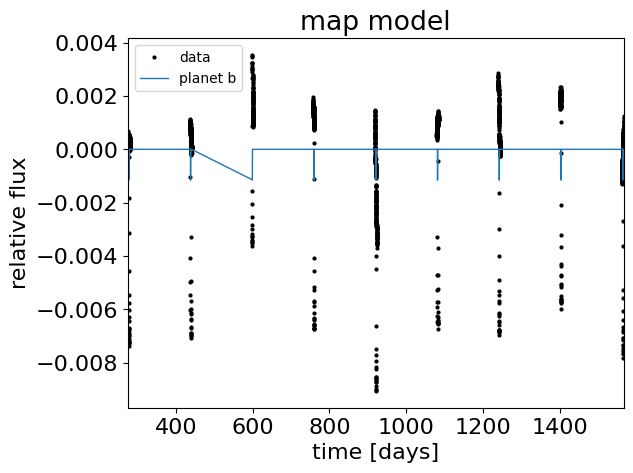

In [76]:
plt.plot(x, y, ".k", ms=4, label="data")
for i, l in enumerate("b"):
    plt.plot(
        x, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(x.min(), x.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

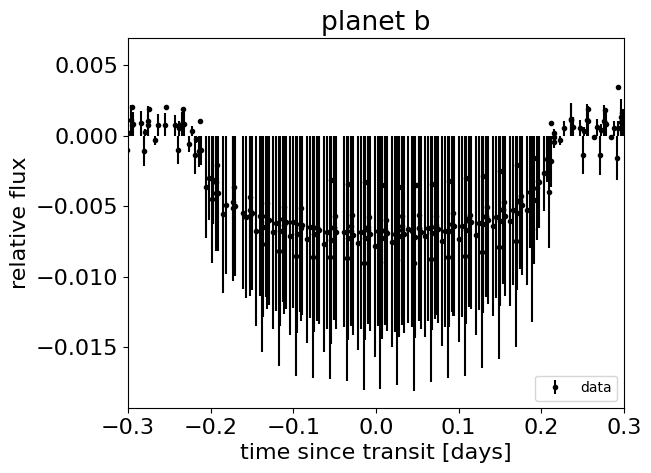

In [77]:
with model:
    t_warp = pmx.eval_in_model(orbit._warp_times(x), map_soln)

for n, letter in enumerate("b"):
    plt.figure()

    p = map_soln["period"][n]

    # NOTE: 't0' has already been subtracted!
    x_fold = (t_warp[:, n] + 0.5 * p) % p - 0.5 * p
    plt.errorbar(
        x_fold, y, yerr=yerr, fmt=".k", label="data", zorder=-1000
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

In [78]:
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=2,
        chains=2,
        return_inferencedata=True,
    )

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'mean': array(0.), 'u_quadlimbdark__': array([-1.09861229, -0.84729786]), 'logr_interval__': array([-3.88578059e-16]), 'b_impact__': array([-5.12885633]), 'tts_0': array([ 277.504085  ,  438.38873587,  599.27338674,  760.15803761,
        921.04268848, 1081.92733935, 1242.81199022, 1403.69664109,
       1564.58129196]), 'u': array([0.3, 0.2]), 'logr': array([-3.45387764]), 'r': array([0.03162278]), 'b': array([0.00607466]), 't0': array([277.504085]), 'period': array([160.88465087]), 'ttvs_0': array([-4.54747351e-13, -4.54747351e-13, -4.54747351e-13, -4.54747351e-13,
       -4.54747351e-13, -2.27373675e-13, -2.27373675e-13, -2.27373675e-13,
        0.00000000e+00]), 'light_curves': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])}

Initial evaluation results:
mean               -0.92
u_quadlimbdark__   -3.23
logr_interval__    -1.39
b_impact__         -5.14
tts_0              -8.27
obs                 -inf
Name: Log-probability of test_point, dtype: float64

In [70]:
import arviz as az

az.summary(trace, var_names=["mean", "u", "r", "b", "tts_0", "period"])

NameError: name 'trace' is not defined

In [7]:
trace.to_netcdf("my_trace.cdf")

NameError: name 'trace' is not defined

In [67]:
import netCDF4 as nc
fn = 'my_trace.cdf'
ds = nc.Dataset(fn)

In [78]:
import arviz
data = arviz.from_netcdf("my_trace.cdf")
print(data==trace)


True


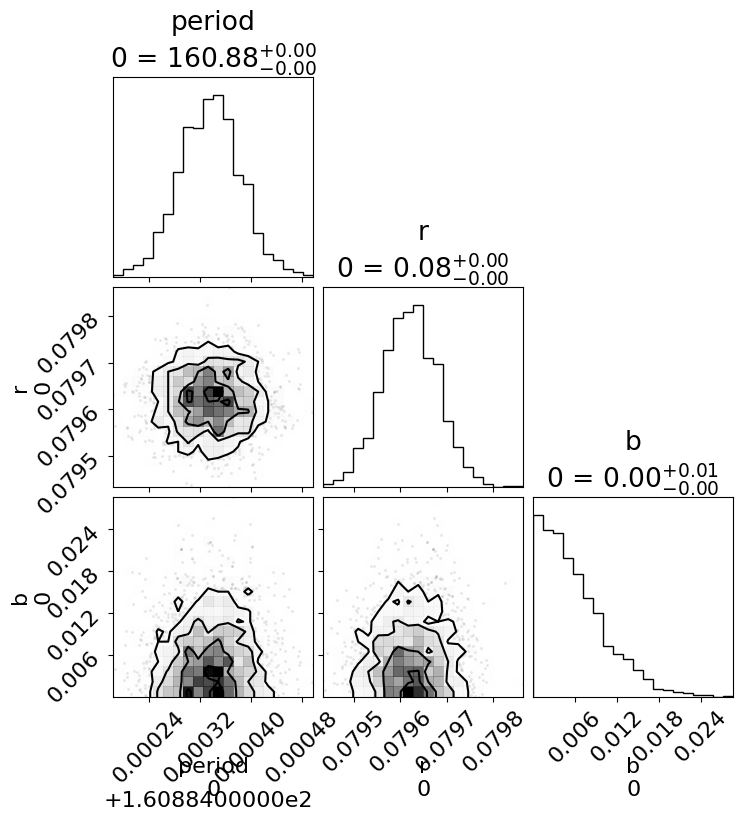

In [1084]:
import corner

names = ["period", "r", "b"]


_ = corner.corner(
    trace,
    var_names=names,
    show_titles=True
)

In [1085]:
tts_median = []
ttvs_median = []
P_median = np.quantile(trace.posterior["period"].values, 0.5)
t0_median = np.median(trace.posterior["t0"].values)

tts_err = []
ttvs_err = []
for ii in range(0, len(t0s)):
    tts = np.median(trace.posterior["tts_0"].values[:, :, ii])
    ttvs = 24.*60.*np.median(trace.posterior["ttvs_0"].values[:, :, ii])
    
    tts_median.append(tts)
    ttvs_median.append(ttvs)
    
    
    tts_quantile = [np.quantile(trace.posterior["tts_0"].values[:, :, ii], 0.16),
                    np.quantile(trace.posterior["tts_0"].values[:, :, ii], 0.84)]
    ttvs_quantile = [24.*60.*np.quantile(trace.posterior["ttvs_0"].values[:, :, ii], 0.16),
                     24.*60.*np.quantile(trace.posterior["ttvs_0"].values[:, :, ii], 0.84)]
    
    tts_err.append(np.array([
        tts - tts_quantile[0],
        tts_quantile[1] - tts
    ]))
    ttvs_err.append(np.array([
        ttvs - ttvs_quantile[0],
        ttvs_quantile[1] - ttvs
    ]))
    

tts_err = np.array(tts_err).T
ttvs_err = np.array(ttvs_err).T



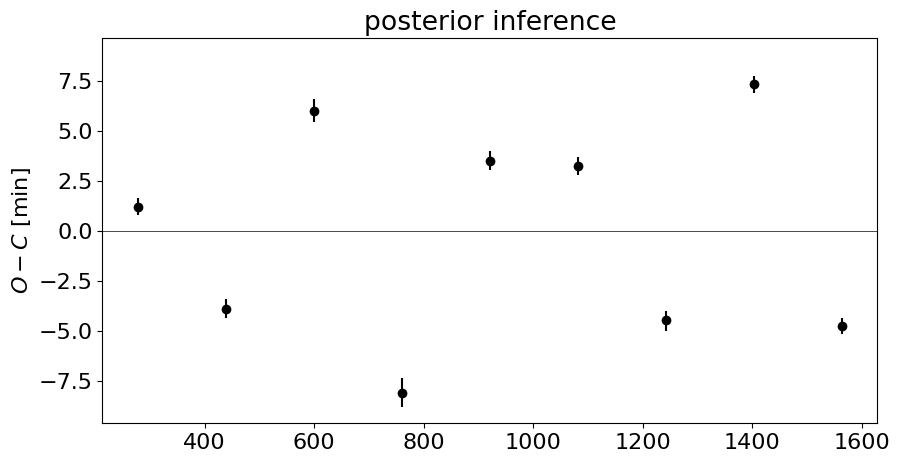

In [1086]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

ax1.errorbar(tts_median, ttvs_median, xerr = tts_err, yerr = ttvs_err, ls = '', marker = 'o', color = 'k')
ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))

ax1.set_ylabel("$O-C$ [min]")


_ = ax1.set_title("posterior inference")

1.1994012209015636
1.192966100729791
-3.88683553215742
-3.8925812200022847
6.0010735725700215
6.010413096310003
-8.081732891969295
-8.090191071851223
3.5098909989756066
3.5043075488829345
3.232487173481786
3.2200093410210684
-4.485513308827649
-4.481697274368344
7.31534301150532
7.313608896256483
-4.775686518842122
-4.7739208593156945
277.50630467409303
160.8843361711165

holczer
3.5673493060312467
3.984702898305841
4.81941008269132
5.236763674965914
5.654117267404217
6.071470859678811
6.4888244519534055
6.906178044228

kipping
-0.975626207600726
-4.142474094569479
-1.1673048200646008
-6.7841499898531765
3.045247900645336
2.0617107444559224
-4.794107810521382
7.478927405172726
-4.868453409653739


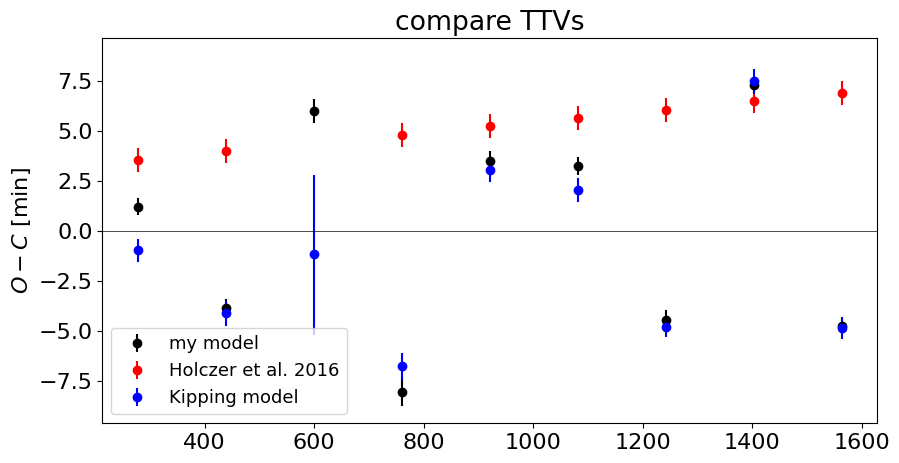

In [1164]:
t_offset = 2454900 - 2454833 

time_model = []
for ii in range(0,9):
    time_model.append(t0_median+(P_median*ii))
    print(24. * 60. * (tts_median[ii]-time_model[ii]))
    print(ttvs_median[ii])
    
print(t0_median)
print(P_median)


    
'''
holczer Vizier data
N	T_i[days]	err[min]
0	210.508782	6e-01
1	371.393408	6e-01
3	693.162660	6e-01
4	854.047286	6e-01
5	1014.931912	6e-01
6	1175.816538	6e-01
7	1336.701164	6e-01
8	1497.585790	6e-01

Period
160.88462604


my period
160.8843361711165

'''
    
print('')
print("holczer")
x_holczer = np.array([210.508782, 371.393408, 693.162660, 854.047286, 1014.931912, 1175.816538, 1336.701164, 1497.585790])
x_holczer += t_offset
y_holczer = []
epoch = 0
for time in x_holczer:
    if epoch == 2:
        epoch += 1
        
    print(24. * 60. * (time-time_model[epoch]))
    y_holczer.append(24. * 60. * (time-time_model[epoch]))
    epoch+=1
    

#y_holczer = np.array([3.6400, -3.6800, -6.0300, 4.5100, 3.0200, -4.2100, 8.1400, -5.3800])
yerr_holczer = np.array([6e-01, 6e-01, 6e-01, 6e-01, 6e-01, 6e-01, 6e-01, 6e-01])

x_kipping = np.array([55110.505627155893, 55271.387764127088, 55432.274166387979,
                      55593.154601972172, 55754.045764114046, 55914.929417273248, 
                      56075.808992459257, 56236.701851571495, 56397.577613172602])
yerr_kipping = np.array([
    [0.000402962774, 0.000399917204],
    [0.000440256757, 0.000441709722],
    [0.002814652733, 0.002745562269],
    [0.00046894051, 0.000469475679],
    [0.000409040716, 0.000403825223],
    [0.000424959595, 0.000417035772],
    [0.000362309329, 0.000367076056],
    [0.000423798963, 0.000430076718],
    [0.000367674438, 0.000366104934]]).T
yerr_kipping = 24.*60.*yerr_kipping

print('')
print("kipping")
x_kipping -= 54833 
y_kipping = []
epoch = 0
for time in x_kipping:
    y_kipping.append(24. * 60. * (time-time_model[epoch]))
    print(24. * 60. * (time-time_model[epoch]))
    epoch+=1
    
'''    
# for TTVs comparison, read in times and then subtract out ephemeris information
0	55110.505627155893	0.000402962774	0.000399917204	1.087096278	0.580266395	0.575880774
1	55271.387764127088	0.000440256757	0.000441709722	-2.265761699	0.633969731	0.636062
2	55432.274166387979	0.002814652733	0.002745562269	0.523397485	4.053099936	3.953609668
3	55593.154601972172	0.00046894051	0.000469475679	-5.279457775	0.675274335	0.676044978
4	55754.045764114046	0.000409040716	0.000403825223	4.363930026	0.589018632	0.581508321
5	55914.929417273248	0.000424959595	0.000417035772	3.194382779	0.611941817	0.600531511
6	56075.808992459257	0.000362309329	0.000367076056	-3.847445866	0.521725434	0.528589521
7	56236.701851571495	0.000423798963	0.000430076718	8.23957926	0.610270507	0.619310473
8	56397.577613172602	0.000367674438	0.000366104934	-4.293811645	0.529451191	0.527191105
'''



fig, ax1 = plt.subplots(1, 1, figsize=(10, 5), sharex=True)


ax1.errorbar(tts_median, ttvs_median, yerr = ttvs_err, ls = '', marker = 'o', color = 'k', label = "my model")
ax1.errorbar(x_holczer, y_holczer, yerr = yerr_holczer, ls = '', marker = 'o', color = 'r', label = "Holczer et al. 2016")
ax1.errorbar(x_kipping, y_kipping, yerr = yerr_kipping, ls = '', marker = 'o', color = 'b', label = "Kipping model")

ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))

ax1.set_ylabel("$O-C$ [min]")

ax1.legend(fontsize = 13, loc=3)
_ = ax1.set_title("compare TTVs")             

In [1163]:
plt.plot(x_holczer, x_holczer-[tts_median[0:2]+tts_median[4:]], 'o')

ValueError: operands could not be broadcast together with shapes (8,) (1,7) 


holczer
399612.64608
631286.50752
1094634.2304
1326308.09184
1557981.95328
1789655.8147200001
2021329.67616
2253003.5376

kipping
399608.10310448636
631278.3803430072
862954.7995986894
1094622.6268399274
1326305.9003242257
1557978.360873477
1789644.9491413299
2021330.6662629533
2252991.7629685462


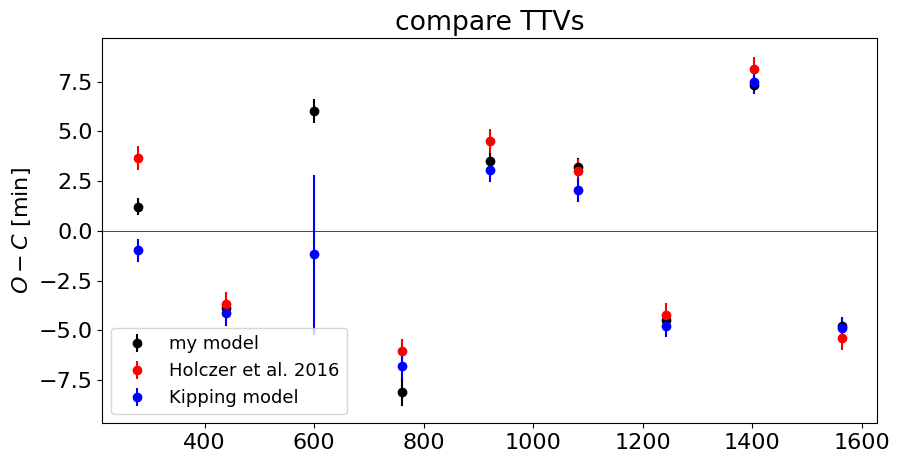

In [1092]:
t_offset = 2454900 - 2454833 

time_model = []
for ii in range(0,9):
    time_model.append(t0_median+(P_median*ii))
    #print(24. * 60. * (tts_median[ii]-time_model[ii]))
    #print(ttvs_median[ii])
    
    
    
print('')
print("holczer")
x_holczer = np.array([210.508782, 371.393408, 693.162660, 854.047286, 1014.931912, 1175.816538, 1336.701164, 1497.585790])
x_holczer += t_offset
y_holczer = []
epoch = 0
for time in x_holczer:
    if epoch == 2:
        epoch += 1
        
    #print(24. * 60. * (time-time_model[epoch]))
    y_holczer.append(24. * 60. * (time-time_model[epoch]))
    epoch+=1
    

y_holczer = np.array([3.6400, -3.6800, -6.0300, 4.5100, 3.0200, -4.2100, 8.1400, -5.3800])
yerr_holczer = np.array([6e-01, 6e-01, 6e-01, 6e-01, 6e-01, 6e-01, 6e-01, 6e-01])

x_kipping = np.array([55110.505627155893, 55271.387764127088, 55432.274166387979,
                      55593.154601972172, 55754.045764114046, 55914.929417273248, 
                      56075.808992459257, 56236.701851571495, 56397.577613172602])
x_kipping -= 54833 

for ii in range(0, len(x_holczer)):
    print(24.*60.*x_holczer[ii])
    
yerr_kipping = np.array([
    [0.000402962774, 0.000399917204],
    [0.000440256757, 0.000441709722],
    [0.002814652733, 0.002745562269],
    [0.00046894051, 0.000469475679],
    [0.000409040716, 0.000403825223],
    [0.000424959595, 0.000417035772],
    [0.000362309329, 0.000367076056],
    [0.000423798963, 0.000430076718],
    [0.000367674438, 0.000366104934]]).T
yerr_kipping = 24.*60.*yerr_kipping

print('')
print("kipping")
y_kipping = []
epoch = 0
for time in x_kipping:
    y_kipping.append(24. * 60. * (time-time_model[epoch]))
    #print(24. * 60. * (time-time_model[epoch]))
    epoch+=1
    
    

for ii in range(0, len(x_kipping)):
    print(24.*60.*x_kipping[ii])
    
'''    
# for TTVs comparison, read in times and then subtract out ephemeris information
0	55110.505627155893	0.000402962774	0.000399917204	1.087096278	0.580266395	0.575880774
1	55271.387764127088	0.000440256757	0.000441709722	-2.265761699	0.633969731	0.636062
2	55432.274166387979	0.002814652733	0.002745562269	0.523397485	4.053099936	3.953609668
3	55593.154601972172	0.00046894051	0.000469475679	-5.279457775	0.675274335	0.676044978
4	55754.045764114046	0.000409040716	0.000403825223	4.363930026	0.589018632	0.581508321
5	55914.929417273248	0.000424959595	0.000417035772	3.194382779	0.611941817	0.600531511
6	56075.808992459257	0.000362309329	0.000367076056	-3.847445866	0.521725434	0.528589521
7	56236.701851571495	0.000423798963	0.000430076718	8.23957926	0.610270507	0.619310473
8	56397.577613172602	0.000367674438	0.000366104934	-4.293811645	0.529451191	0.527191105
'''



fig, ax1 = plt.subplots(1, 1, figsize=(10, 5), sharex=True)


ax1.errorbar(tts_median, ttvs_median, yerr = ttvs_err, ls = '', marker = 'o', color = 'k', label = "my model")
ax1.errorbar(x_holczer, y_holczer, yerr = yerr_holczer, ls = '', marker = 'o', color = 'r', label = "Holczer et al. 2016")
ax1.errorbar(x_kipping, y_kipping, yerr = yerr_kipping, ls = '', marker = 'o', color = 'b', label = "Kipping model")

ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))

ax1.set_ylabel("$O-C$ [min]")

ax1.legend(fontsize = 13, loc=3)
_ = ax1.set_title("compare TTVs") 